In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Libraries for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [8]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")

# Create models directory if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Load datasets
analysis_df = pd.read_csv('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data/nifty_analysis_results.csv')
vix_df = pd.read_csv('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data/india_vix.csv')
nifty_df = pd.read_csv('/Users/priyeshgupta/sandbox/strategy-data-analysis/nifty-3weeks-expiry/data/nifty_data.csv')

# Display the first few rows of each dataset
print("Nifty Analysis Results:")
display(analysis_df.head())

print("\nIndia VIX Data:")
display(vix_df.head())

print("\nNifty Hourly Data:")
display(nifty_df.head())

Nifty Analysis Results:


,monday_date,monday_day,monday_open,monday_low,monday_high,monday_close,monday_volume,expiry_date,expiry_day,expiry_open,expiry_low,expiry_high,expiry_close,expiry_volume,3_week_high,3_week_low,monday_close_minus_expiry_close,3_week_high_minus_monday_close,3_week_low_minus_monday_close,3_week_high_minus_thursday_close,3_week_low_minus_thursday_close
0,2021-03-01,Monday,14709.95,14658.50,14791.00,14753.65,3666450,2021-03-18,Thursday,14868.25,14837.9,14900.25,14845.0,2840775,15375.00,14658.5,-91.35,621.35,-95.15,530.00,-186.5
1,2021-03-08,Monday,15001.20,14980.10,15140.00,15115.35,3194775,2021-03-25,Thursday,14560.00,14410.5,14560.00,14432.0,2319750,15375.00,14371.3,683.35,259.65,-744.05,943.00,-60.7
2,2021-03-15,Monday,15050.00,14836.55,15068.95,14884.05,3748350,2021-04-01,Thursday,14823.10,14811.0,14879.00,14836.0,2465100,15068.95,14371.3,48.05,184.90,-512.75,232.95,-464.7
3,2021-03-22,Monday,14741.05,14665.10,14779.90,14743.15,2768775,2021-04-08,Thursday,14939.80,14925.5,15020.00,15002.0,2163000,15020.00,14410.5,-258.85,276.85,-332.65,18.00,-591.5
4,2021-04-05,Monday,14890.00,14594.40,14899.85,14612.00,5129625,2021-04-22,Thursday,14200.00,14155.0,14277.70,14249.3,2968200,15020.00,14155.0,362.70,408.00,-457.00,770.70,-94.3



India VIX Data:


,datetime,open,high,low,close
0,2020-07-06 12:15:00,25.4100,25.4225,25.1550,25.2775
1,2020-07-06 13:15:00,25.2800,25.5175,25.2075,25.4525
2,2020-07-06 14:15:00,25.4550,25.4950,25.1450,25.1550
3,2020-07-06 15:15:00,25.1525,25.2325,25.0725,25.0825
4,2020-07-07 09:15:00,25.1975,25.6450,24.2400,25.1300



Nifty Hourly Data:


,time,open,high,low,close,Volume,Volume MA
0,1614570300,14709.95,14791.00,14658.50,14753.65,3666450,NaN
1,1614573900,14753.25,14839.45,14753.25,14819.10,1563900,NaN
2,1614577500,14819.10,14828.00,14716.75,14753.25,1762125,NaN
3,1614581100,14752.40,14783.00,14676.05,14771.05,1667550,NaN
4,1614584700,14772.50,14829.85,14734.40,14803.40,1321425,NaN


In [9]:
# Convert date columns to datetime
analysis_df['monday_date'] = pd.to_datetime(analysis_df['monday_date'])
analysis_df['expiry_date'] = pd.to_datetime(analysis_df['expiry_date'])
vix_df['datetime'] = pd.to_datetime(vix_df['datetime'])

# Extract date from datetime for easier merging later
vix_df['date'] = vix_df['datetime'].dt.date
vix_df['date'] = pd.to_datetime(vix_df['date'])

# If nifty_df time column needs conversion
nifty_df['time'] = pd.to_datetime(nifty_df['time'])
nifty_df['date'] = nifty_df['time'].dt.date
nifty_df['date'] = pd.to_datetime(nifty_df['date'])

# Check for missing values and handle them
print("Missing values in datasets:")
print(analysis_df.isnull().sum().sum(), "missing values in analysis_df")
print(vix_df.isnull().sum().sum(), "missing values in vix_df")
print(nifty_df.isnull().sum().sum(), "missing values in nifty_df")

Missing values in datasets:
0 missing values in analysis_df
0 missing values in vix_df
9 missing values in nifty_df


In [10]:
# Fill missing values or drop them as appropriate
analysis_df = analysis_df.fillna(0)
vix_df = vix_df.dropna()
nifty_df = nifty_df.dropna()

# Merge VIX data with analysis_df
# First, filter VIX data to get only the first hour of Mondays
vix_df['day_of_week'] = vix_df['datetime'].dt.dayofweek
vix_df['hour'] = vix_df['datetime'].dt.hour
monday_first_hour_vix = vix_df[(vix_df['day_of_week'] == 0) & (vix_df['hour'] == vix_df['datetime'].dt.hour.min())]

# Group by date to get one record per day
monday_vix = monday_first_hour_vix.groupby('date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
}).rename(columns={'open': 'vix_open', 'high': 'vix_high', 'low': 'vix_low', 'close': 'vix_close'}).reset_index()

# Convert monday_date to date format for merging
analysis_df['monday_date_only'] = analysis_df['monday_date'].dt.date
analysis_df['monday_date_only'] = pd.to_datetime(analysis_df['monday_date_only'])

# Merge the dataframes
merged_df = pd.merge(analysis_df, monday_vix, left_on='monday_date_only', right_on='date', how='inner')
print(f"Merged DataFrame has {len(merged_df)} rows with both Nifty and VIX data")

# Feature engineering
# Calculate range percentages
merged_df['range_3week'] = merged_df['3_week_high'] - merged_df['3_week_low']
merged_df['range_pct'] = merged_df['range_3week'] / merged_df['monday_close'] * 100
merged_df['high_range_pct'] = (merged_df['3_week_high'] - merged_df['monday_close']) / merged_df['monday_close'] * 100
merged_df['low_range_pct'] = (merged_df['monday_close'] - merged_df['3_week_low']) / merged_df['monday_close'] * 100

# Extract time-based features
merged_df['month'] = merged_df['monday_date'].dt.month
merged_df['year'] = merged_df['monday_date'].dt.year
merged_df['week_of_year'] = merged_df['monday_date'].dt.isocalendar().week
merged_df['day_of_year'] = merged_df['monday_date'].dt.dayofyear

# Calculate price momentum features
merged_df['weekly_change'] = merged_df['monday_close'].pct_change() * 100
merged_df['price_to_3wk_high_ratio'] = merged_df['monday_close'] / merged_df['3_week_high']
merged_df['price_to_3wk_low_ratio'] = merged_df['monday_close'] / merged_df['3_week_low']

# Calculate volatility features
merged_df['monday_range'] = (merged_df['monday_high'] - merged_df['monday_low']) / merged_df['monday_close'] * 100
merged_df['vix_range'] = (merged_df['vix_high'] - merged_df['vix_low']) / merged_df['vix_close'] * 100

# Create rolling window features (will result in NaN for first few rows)
merged_df = merged_df.sort_values('monday_date')
merged_df['prev_week_range'] = merged_df['range_pct'].shift(1)
merged_df['prev_week_vix_close'] = merged_df['vix_close'].shift(1)
merged_df['vix_week_change'] = merged_df['vix_close'].pct_change() * 100

# Create more advanced features
merged_df['price_momentum'] = merged_df['monday_close'].pct_change(3) * 100  # 3-week momentum
merged_df['vix_momentum'] = merged_df['vix_close'].pct_change(3) * 100      # 3-week VIX momentum
merged_df['price_vix_ratio'] = merged_df['monday_close'] / merged_df['vix_close']

# Drop rows with NaN from new features
merged_df = merged_df.dropna()

# Display the enhanced dataset
display(merged_df.head())

Merged DataFrame has 196 rows with both Nifty and VIX data


,monday_date,monday_day,monday_open,monday_low,monday_high,monday_close,monday_volume,expiry_date,expiry_day,expiry_open,expiry_low,expiry_high,expiry_close,expiry_volume,3_week_high,3_week_low,monday_close_minus_expiry_close,3_week_high_minus_monday_close,3_week_low_minus_monday_close,3_week_high_minus_thursday_close,3_week_low_minus_thursday_close,monday_date_only,date,vix_open,vix_high,vix_low,vix_close,range_3week,range_pct,high_range_pct,low_range_pct,month,year,week_of_year,day_of_year,weekly_change,price_to_3wk_high_ratio,price_to_3wk_low_ratio,monday_range,vix_range,prev_week_range,prev_week_vix_close,vix_week_change,price_momentum,vix_momentum,price_vix_ratio
3,2021-03-22,Monday,14741.05,14665.1,14779.90,14743.15,2768775,2021-04-08,Thursday,14939.80,14925.50,15020.0,15002.00,2163000,15020.0,14410.5,-258.85,276.85,-332.65,18.00,-591.50,2021-03-22,2021-03-22,19.9875,20.9175,18.9700,20.5050,609.5,4.134123,1.877821,2.256302,3,2021,12,81,-0.946651,0.981568,1.023084,0.778667,9.497683,4.687232,22.4250,-8.561873,-0.071169,-23.481668,719.002682
4,2021-04-05,Monday,14890.00,14594.4,14899.85,14612.00,5129625,2021-04-22,Thursday,14200.00,14155.00,14277.7,14249.30,2968200,15020.0,14155.0,362.70,408.00,-457.00,770.70,-94.30,2021-04-05,2021-04-05,19.9875,22.7825,19.9875,22.5075,865.0,5.919792,2.792226,3.127566,4,2021,14,95,-0.889566,0.972836,1.032285,2.090405,12.418083,4.134123,20.5050,9.765911,-3.330059,-8.207586,649.205820
5,2021-04-12,Monday,14689.70,14424.0,14689.70,14471.35,5857800,2021-04-29,Thursday,15010.00,14900.10,15035.0,14919.30,2501175,15035.0,14155.0,-447.95,563.65,-316.35,115.70,-764.30,2021-04-12,2021-04-12,19.7850,22.9350,19.7850,22.0275,880.0,6.080981,3.894937,2.186043,4,2021,15,102,-0.962565,0.962511,1.022349,1.836042,14.300306,5.919792,22.5075,-2.132622,-2.772767,-1.772575,656.967427
6,2021-04-19,Monday,14399.00,14213.0,14399.00,14311.00,5886975,2021-05-06,Thursday,14717.95,14687.15,14746.0,14702.35,2107500,15035.0,14155.0,-391.35,724.00,-156.00,332.65,-547.35,2021-04-19,2021-04-19,20.4025,23.1075,19.8075,22.2400,880.0,6.149116,5.059045,1.090071,4,2021,16,109,-1.108051,0.951846,1.011021,1.299700,14.838129,6.080981,22.0275,0.964703,-2.931192,8.461351,643.480216
7,2021-04-26,Monday,14442.35,14423.4,14552.45,14525.00,3042075,2021-05-12,Wednesday,14842.10,14734.00,14842.1,14743.90,3439275,15035.0,14423.4,-218.90,510.00,-101.60,291.10,-320.50,2021-04-26,2021-04-26,22.6900,23.4075,22.6175,23.2550,611.6,4.210671,3.511188,0.699484,4,2021,17,116,1.495353,0.966079,1.007044,0.888468,3.397119,6.149116,22.2400,4.563849,-0.595401,3.321115,624.596861


In [11]:
# Create target variables for different prediction tasks

# 1. Regression target: 3-week range percentage
y_reg = merged_df['range_pct']

# 2. Classification target: Whether the range is above average (binary)
avg_range = merged_df['range_pct'].mean()
merged_df['above_avg_range'] = (merged_df['range_pct'] > avg_range).astype(int)
y_class = merged_df['above_avg_range']

# 3. Multi-class target: Range categories (Small, Medium, Large)
range_quantiles = merged_df['range_pct'].quantile([0.33, 0.67])
merged_df['range_category'] = pd.cut(merged_df['range_pct'], 
                                     bins=[0, range_quantiles.iloc[0], range_quantiles.iloc[1], float('inf')],
                                     labels=['Small', 'Medium', 'Large'])
y_multiclass = merged_df['range_category']

# Select features for modeling
features = ['monday_close', 'monday_open', 'monday_high', 'monday_low', 'monday_volume',
           'vix_open', 'vix_high', 'vix_low', 'vix_close',
           'month', 'week_of_year', 'weekly_change', 'monday_range', 'vix_range',
           'prev_week_range', 'prev_week_vix_close', 'vix_week_change',
           'price_momentum', 'vix_momentum', 'price_vix_ratio']

X = merged_df[features]

# Split data into training and testing sets
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
_, _, y_multiclass_train, y_multiclass_test = train_test_split(X, y_multiclass, test_size=0.2, random_state=42)

# Create a preprocessor for numerical and categorical features
numeric_features = [col for col in features if col not in ['month', 'week_of_year']]
categorical_features = ['month', 'week_of_year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Print dataset sizes
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Function to evaluate regression models
def evaluate_regression_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print results
    print(f"{model_name} Results:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X, y_reg, cv=5, scoring='r2')
    print(f"Cross-Validation R2 Scores: {cv_scores}")
    print(f"Mean CV R2 Score: {cv_scores.mean():.4f}")
    
    # Plot predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Range %')
    plt.ylabel('Predicted Range %')
    plt.title(f'{model_name}: Actual vs Predicted Range %')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'models/{model_name.lower().replace(" ", "_")}_predictions.png')
    plt.show()
    
    # Feature importance if available
    if hasattr(model, 'feature_importances_') or (hasattr(model, 'named_steps') and hasattr(model.named_steps.get('regressor', None), 'feature_importances_')):
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            importances = model.named_steps['regressor'].feature_importances_
        
        # For pipelines, need to get the feature names after preprocessing
        if hasattr(model, 'named_steps') and 'preprocessor' in model.named_steps:
            # Get feature names from preprocessor
            preprocessor = model.named_steps['preprocessor']
            feature_names = []
            for name, transformer, cols in preprocessor.transformers_:
                if name == 'num':
                    feature_names.extend(cols)
                elif name == 'cat':
                    for col in cols:
                        cats = transformer.categories_[0]
                        feature_names.extend([f"{col}_{cat}" for cat in cats])
            
            # Sort features by importance
            indices = np.argsort(importances)[::-1]
            
            # Plot feature importances
            plt.figure(figsize=(12, 8))
            plt.title(f'Feature Importances - {model_name}')
            plt.bar(range(len(indices)), importances[indices], align='center')
            plt.xticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f"Feature {i}" for i in indices], rotation=90)
            plt.tight_layout()
            plt.savefig(f'models/{model_name.lower().replace(" ", "_")}_feature_importance.png')
            plt.show()
    
    return {
        'model': model,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'cv_r2': cv_scores.mean(),
        'y_pred': y_pred
    }

# Function to evaluate classification models
def evaluate_classification_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Print results
    print(f"{model_name} Classification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X, y_class, cv=5, scoring='accuracy')
    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean CV Accuracy Score: {cv_scores.mean():.4f}")
    
    return {
        'model': model,
        'accuracy': accuracy,
        'cv_accuracy': cv_scores.mean(),
        'y_pred': y_pred
    }

Training set size: (154, 20)
Testing set size: (39, 20)


Linear Regression Results:
Mean Squared Error: 4.5399
Root Mean Squared Error: 2.1307
Mean Absolute Error: 1.6045
R² Score: -0.6600
Cross-Validation R2 Scores: [-1.33473687 -0.50632869 -0.32653836 -1.50625801 -0.24758172]
Mean CV R2 Score: -0.7843


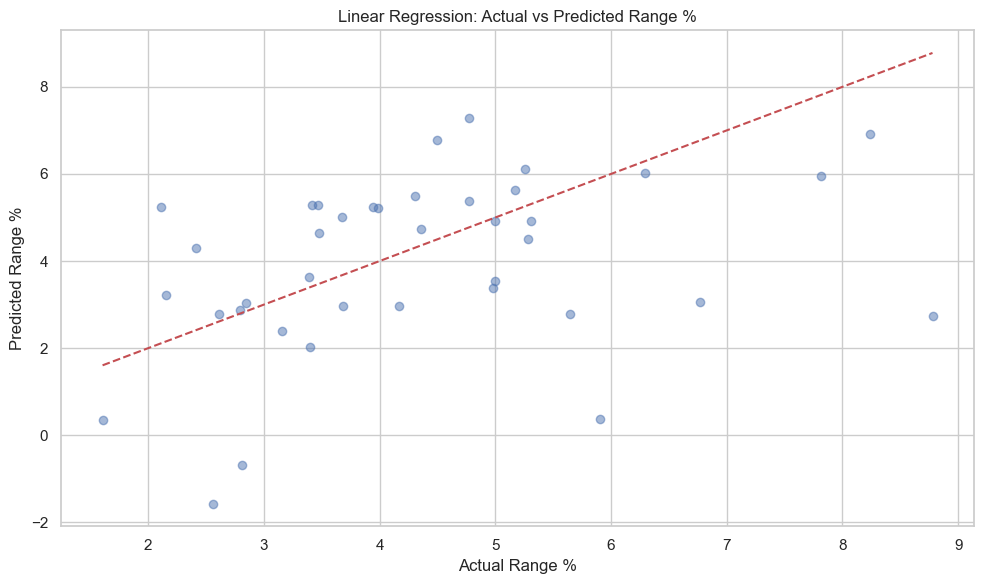

['models/linear_regression_model.pkl']

In [12]:
# Model 1: Linear Regression
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

linear_results = evaluate_regression_model(linear_pipeline, X_train, X_test, y_reg_train, y_reg_test, "Linear Regression")

# Save the model
joblib.dump(linear_pipeline, 'models/linear_regression_model.pkl')

Elastic Net Results:
Mean Squared Error: 1.7082
Root Mean Squared Error: 1.3070
Mean Absolute Error: 1.1156
R² Score: 0.3754
Cross-Validation R2 Scores: [ 0.04831482 -0.02083984 -0.04807236 -0.00134995  0.2777805 ]
Mean CV R2 Score: 0.0512


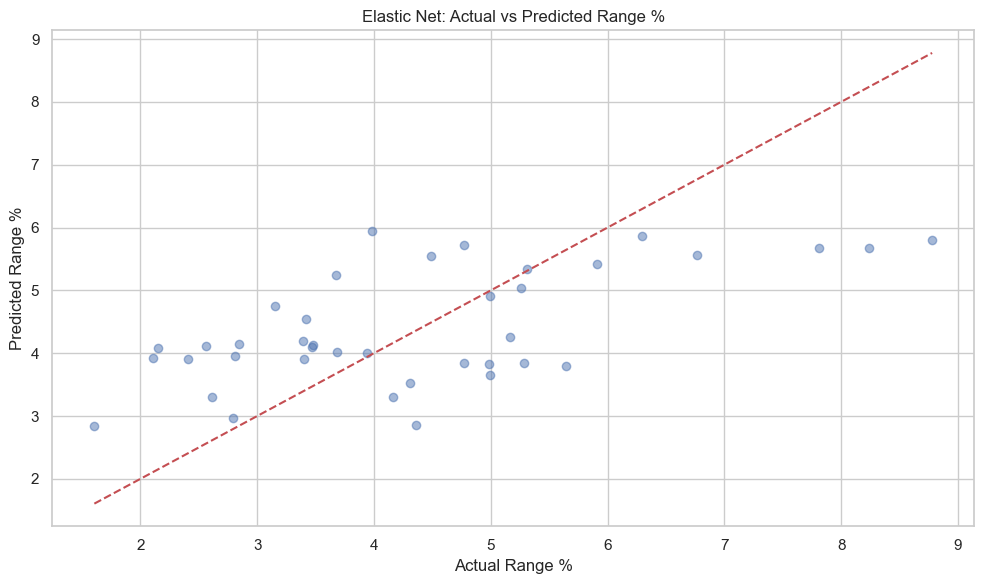

['models/elasticnet_model.pkl']

In [13]:
# Model 2: Elastic Net Regression
elastic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))
])

elastic_results = evaluate_regression_model(elastic_pipeline, X_train, X_test, y_reg_train, y_reg_test, "Elastic Net")

# Save the model
joblib.dump(elastic_pipeline, 'models/elasticnet_model.pkl')

Random Forest Results:
Mean Squared Error: 1.6487
Root Mean Squared Error: 1.2840
Mean Absolute Error: 1.0649
R² Score: 0.3972
Cross-Validation R2 Scores: [-0.18611324 -0.10135251 -0.18249551 -0.07501222  0.29793986]
Mean CV R2 Score: -0.0494


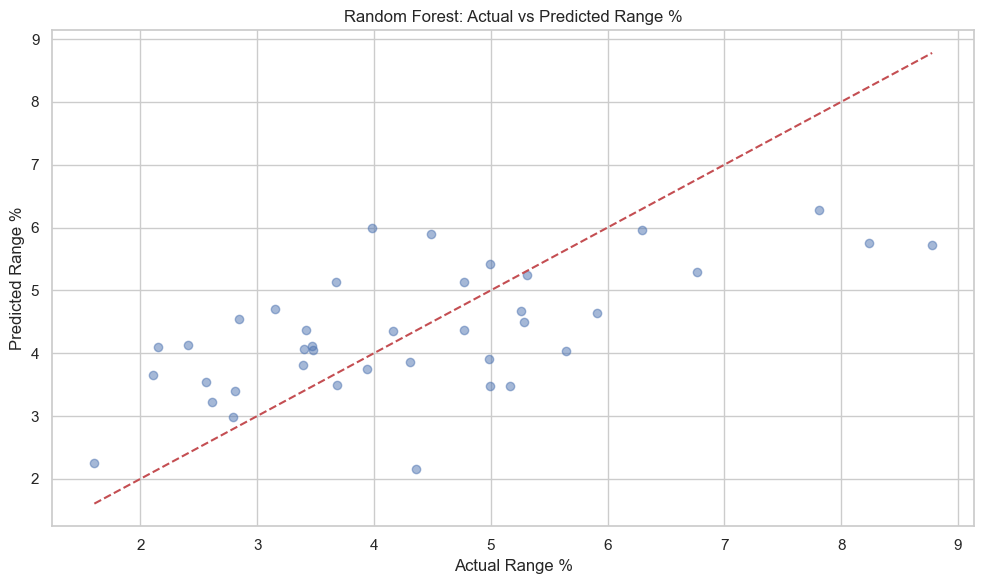

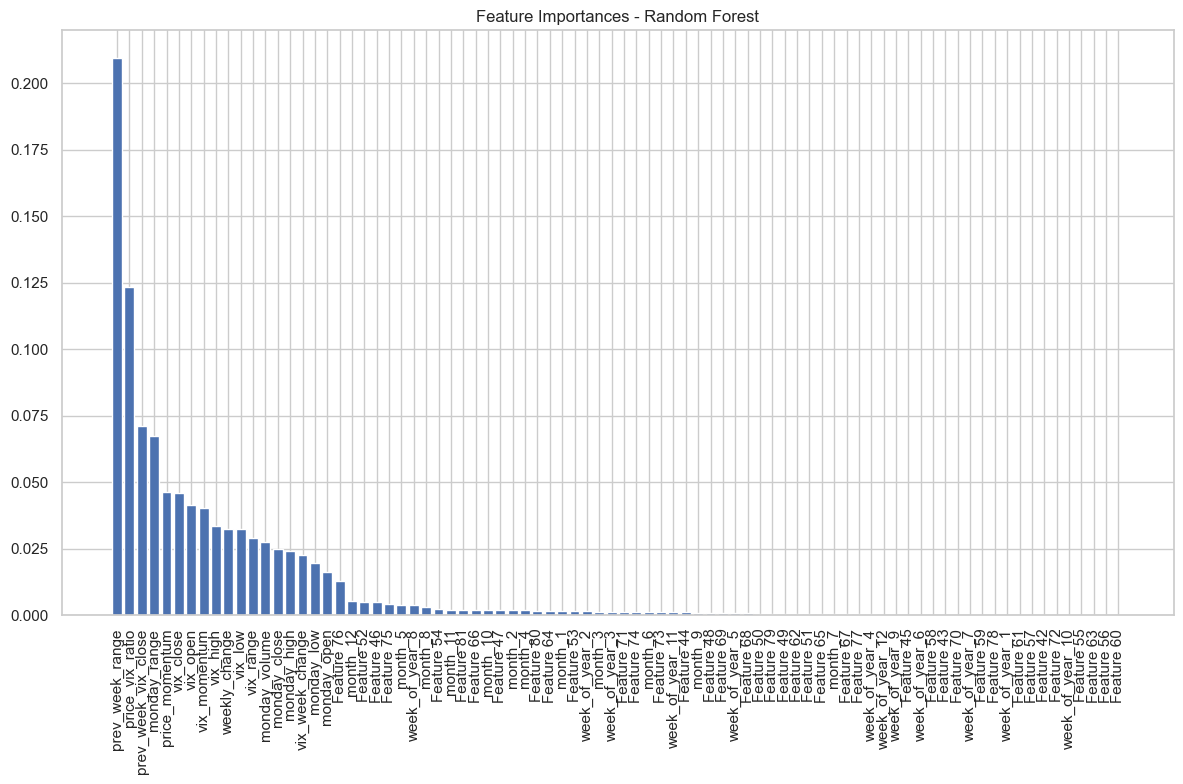

['models/random_forest_model.pkl']

In [14]:
# Model 3: Random Forest Regressor
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_results = evaluate_regression_model(rf_pipeline, X_train, X_test, y_reg_train, y_reg_test, "Random Forest")

# Save the model
joblib.dump(rf_pipeline, 'models/random_forest_model.pkl')

XGBoost Results:
Mean Squared Error: 2.2137
Root Mean Squared Error: 1.4878
Mean Absolute Error: 1.2047
R² Score: 0.1906
Cross-Validation R2 Scores: [-0.29671861 -0.36752943 -0.39263183 -0.40241203  0.46125697]
Mean CV R2 Score: -0.1996


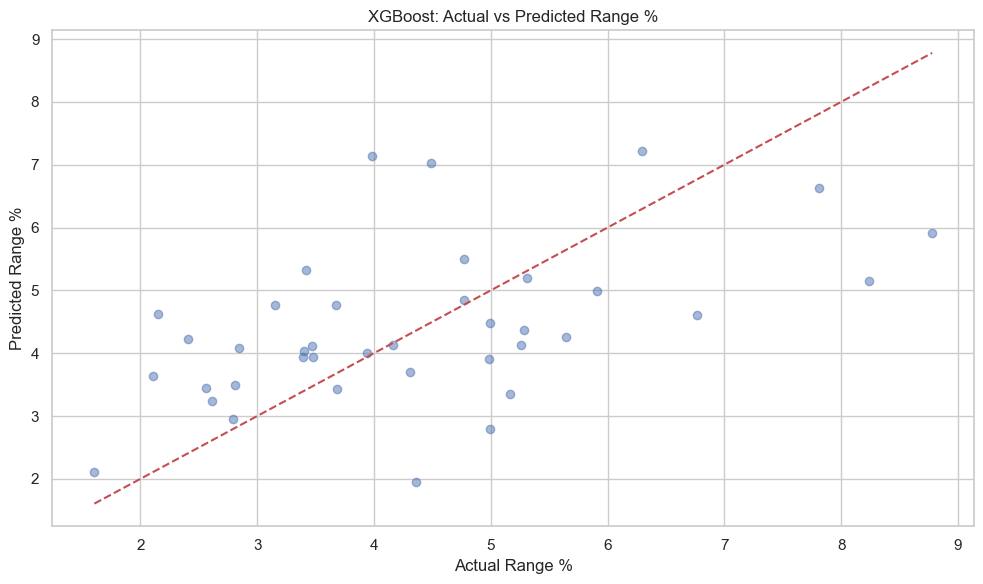

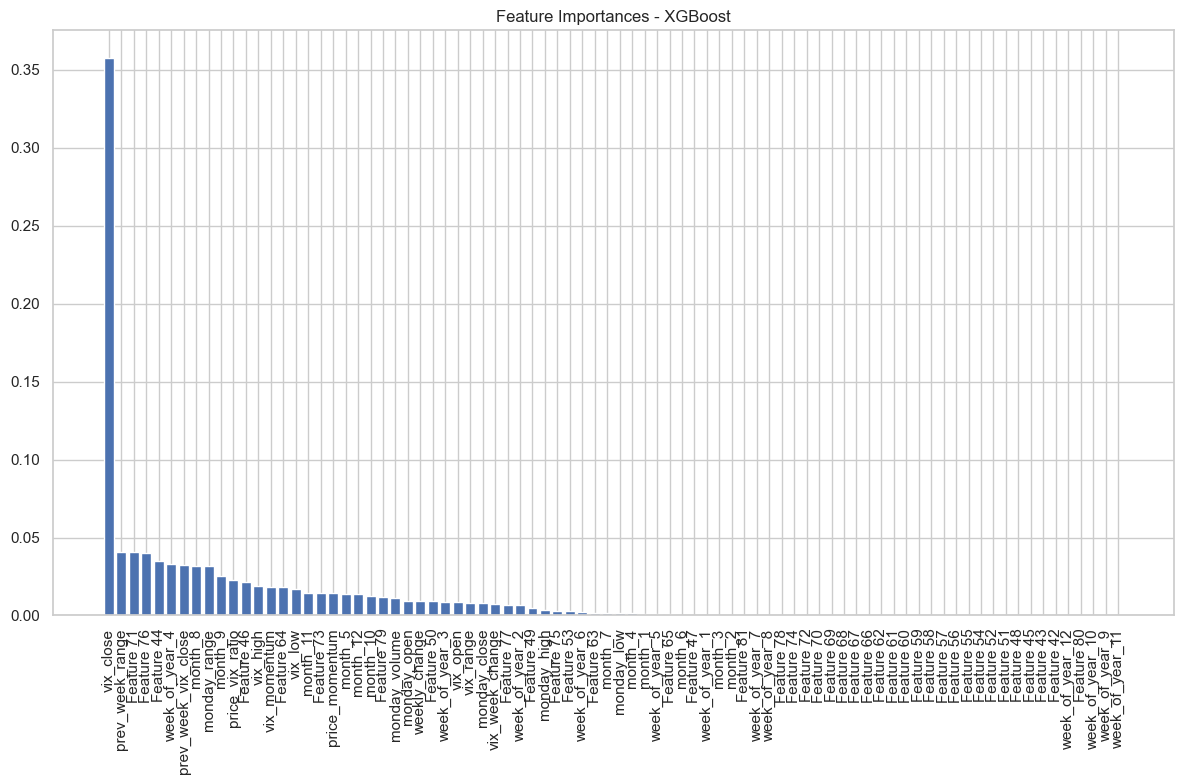

['models/xgboost_model.pkl']

In [15]:
# Model 4: XGBoost Regressor
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42))
])

xgb_results = evaluate_regression_model(xgb_pipeline, X_train, X_test, y_reg_train, y_reg_test, "XGBoost")

# Save the model
joblib.dump(xgb_pipeline, 'models/xgboost_model.pkl')

In [16]:
# Model 5: Logistic Regression for Classification
log_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

log_results = evaluate_classification_model(log_pipeline, X_train, X_test, y_class_train, y_class_test, "Logistic Regression")

# Save the model
joblib.dump(log_pipeline, 'models/logistic_regression_model.pkl')

Logistic Regression Classification Results:
Accuracy: 0.7179
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78        23
           1       0.69      0.56      0.62        16

    accuracy                           0.72        39
   macro avg       0.71      0.69      0.70        39
weighted avg       0.71      0.72      0.71        39

Cross-Validation Accuracy Scores: [0.48717949 0.71794872 0.79487179 0.71052632 0.63157895]
Mean CV Accuracy Score: 0.6684


['models/logistic_regression_model.pkl']

In [17]:
# Compare regression models
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Elastic Net', 'Random Forest', 'XGBoost'],
    'RMSE': [linear_results['rmse'], elastic_results['rmse'], rf_results['rmse'], xgb_results['rmse']],
    'MAE': [linear_results['mae'], elastic_results['mae'], rf_results['mae'], xgb_results['mae']],
    'R²': [linear_results['r2'], elastic_results['r2'], rf_results['r2'], xgb_results['r2']],
    'CV R²': [linear_results['cv_r2'], elastic_results['cv_r2'], rf_results['cv_r2'], xgb_results['cv_r2']]
})

print("Regression Models Comparison:")
display(models_comparison)

Regression Models Comparison:


,Model,RMSE,MAE,R²,CV R²
0,Linear Regression,2.130699,1.604534,-0.659986,-0.784289
1,Elastic Net,1.306976,1.115640,0.375410,0.051167
2,Random Forest,1.284027,1.064875,0.397151,-0.049407
3,XGBoost,1.487847,1.204677,0.190574,-0.199607


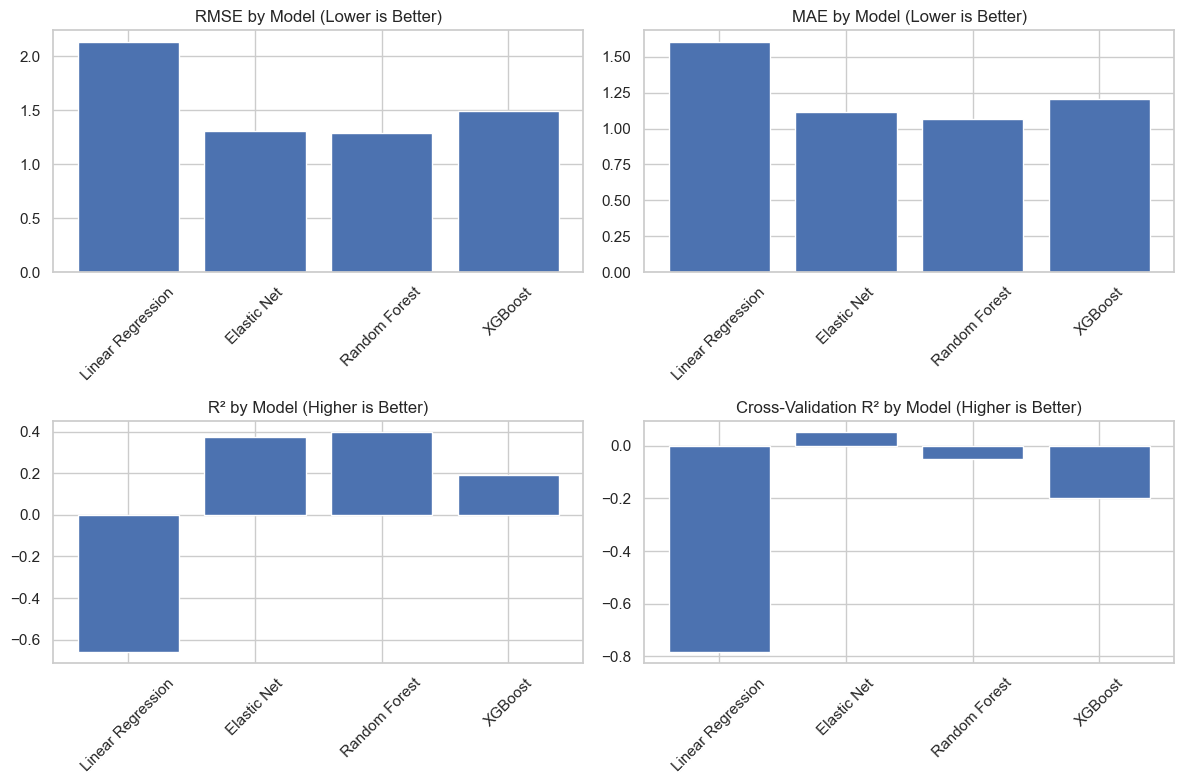

In [18]:
# Visualize model comparison
plt.figure(figsize=(12, 8))

# Plot RMSE
plt.subplot(2, 2, 1)
plt.bar(models_comparison['Model'], models_comparison['RMSE'])
plt.title('RMSE by Model (Lower is Better)')
plt.xticks(rotation=45)
plt.tight_layout()

# Plot MAE
plt.subplot(2, 2, 2)
plt.bar(models_comparison['Model'], models_comparison['MAE'])
plt.title('MAE by Model (Lower is Better)')
plt.xticks(rotation=45)
plt.tight_layout()

# Plot R²
plt.subplot(2, 2, 3)
plt.bar(models_comparison['Model'], models_comparison['R²'])
plt.title('R² by Model (Higher is Better)')
plt.xticks(rotation=45)
plt.tight_layout()

# Plot CV R²
plt.subplot(2, 2, 4)
plt.bar(models_comparison['Model'], models_comparison['CV R²'])
plt.title('Cross-Validation R² by Model (Higher is Better)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('models/regression_models_comparison.png')
plt.show()

Performing hyperparameter tuning for XGBoost. This may take some time...
Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 1, 'regressor__n_estimators': 200}
Best score: 2.2190471049758163
Tuned XGBoost Results:
Mean Squared Error: 1.9782
Root Mean Squared Error: 1.4065
Mean Absolute Error: 1.1456
R² Score: 0.2767
Cross-Validation R2 Scores: [-0.07125678  0.07851771 -0.16343078 -0.24733089  0.20733302]
Mean CV R2 Score: -0.0392


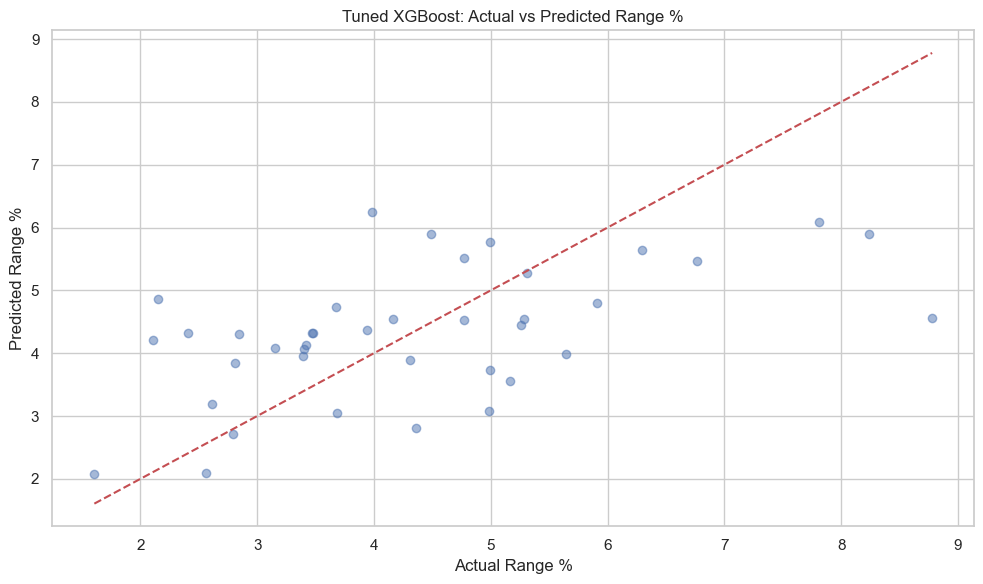

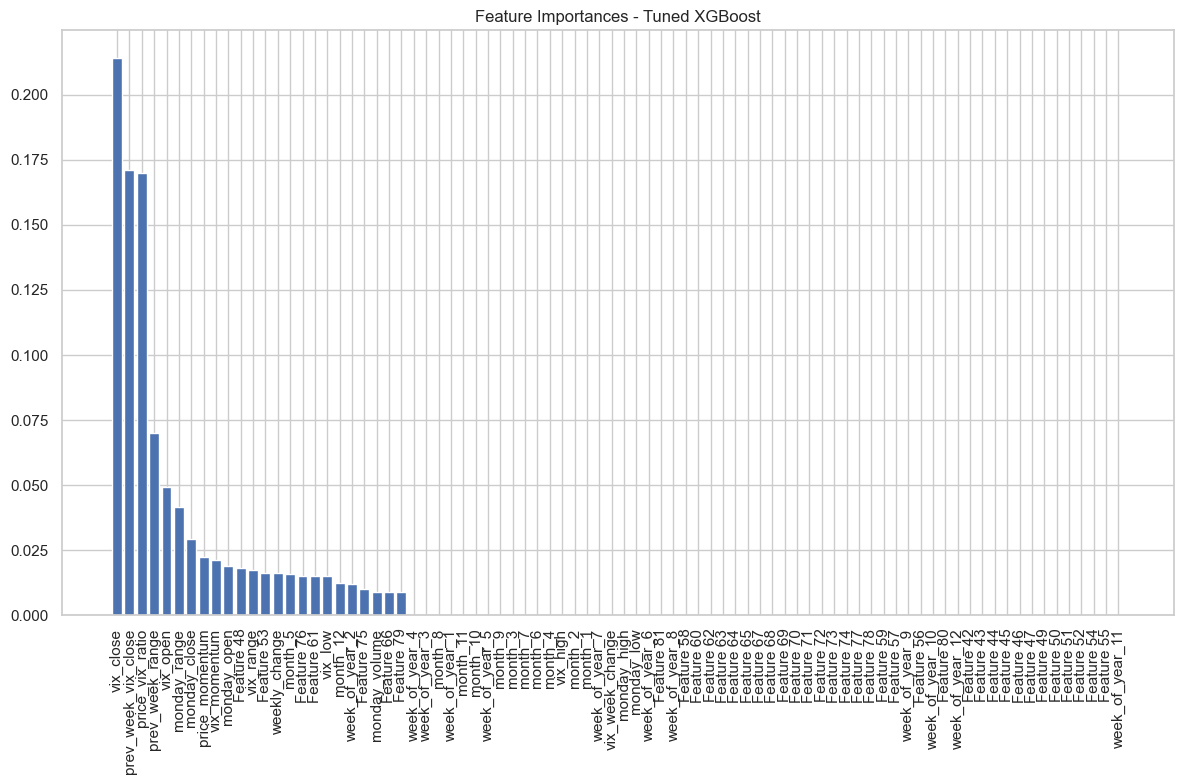

['models/tuned_xgboost_model.pkl']

In [19]:
# Model Hyperparameter Tuning for the Best Performer
# Let's assume XGBoost performed best (adjust based on actual results)

# Define parameter grid
param_grid = {
    'regressor__n_estimators': [10, 20, 30, 50, 100, 200],
    'regressor__learning_rate': [0.01, 0.05, 0.075, 0.10, 0.15],
    'regressor__max_depth': [1, 2, 3, 5, 7]
}

# Create grid search
grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit grid search
print("Performing hyperparameter tuning for XGBoost. This may take some time...")
grid_search.fit(X_train, y_reg_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

# Evaluate the tuned model
tuned_xgb_results = evaluate_regression_model(grid_search.best_estimator_, X_train, X_test, y_reg_train, y_reg_test, "Tuned XGBoost")

# Save the tuned model
joblib.dump(grid_search.best_estimator_, 'models/tuned_xgboost_model.pkl')

In [20]:
# Generate predictions for next week
# Assuming we have the latest data
def prepare_next_week_prediction():
    """
    Prepares the data for next week's prediction.
    In a real-world scenario, this would pull the latest data from a database or API.
    """
    # Get the most recent data point
    latest_data = merged_df.sort_values('monday_date', ascending=False).iloc[0].copy()
    
    # Adjust the date for next Monday (7 days from the last Monday)
    next_monday = pd.to_datetime(latest_data['monday_date']) + pd.Timedelta(days=7)
    
    # Create a dictionary for next week's prediction features
    next_week_data = {feature: latest_data[feature] for feature in features}
    
    # Print prediction date
    print(f"Preparing prediction for Monday: {next_monday.date()}")
    
    return pd.DataFrame([next_week_data])

# Get next week's prediction data
next_week_df = prepare_next_week_prediction()

# Make predictions with all models
def predict_next_week(models):
    """
    Makes predictions for next week using all models.
    
    Args:
        models: Dict of model names and model objects
    
    Returns:
        DataFrame with predictions
    """
    predictions = {}
    
    for name, model in models.items():
        if 'Logistic' in name:
            # Classification model
            pred = model.predict_proba(next_week_df)[0][1]  # Probability of above average range
            predictions[f"{name} (Prob Above Avg)"] = pred
        else:
            # Regression model
            pred = model.predict(next_week_df)[0]
            predictions[f"{name} Range %"] = pred
    
    return pd.DataFrame([predictions])

# Collect all models
models = {
    'Linear Regression': linear_pipeline,
    'Elastic Net': elastic_pipeline,
    'Random Forest': rf_pipeline,
    'XGBoost': xgb_pipeline,
    'Tuned XGBoost': grid_search.best_estimator_,
    'Logistic Regression': log_pipeline
}

# Make predictions
next_week_predictions = predict_next_week(models)

print("\nPredictions for Next Week:")
display(next_week_predictions)

# Save predictions to CSV
next_week_predictions.to_csv('models/next_week_predictions.csv', index=False)
print("Next week predictions saved to 'models/next_week_predictions.csv'")

Preparing prediction for Monday: 2025-02-24

Predictions for Next Week:


,Linear Regression Range %,Elastic Net Range %,Random Forest Range %,XGBoost Range %,Tuned XGBoost Range %,Logistic Regression (Prob Above Avg)
0,4.795046,4.384632,3.854914,3.955308,3.802657,0.176665


Next week predictions saved to 'models/next_week_predictions.csv'



Ensemble Prediction for Next Week 3-Week Range %: 4.16%


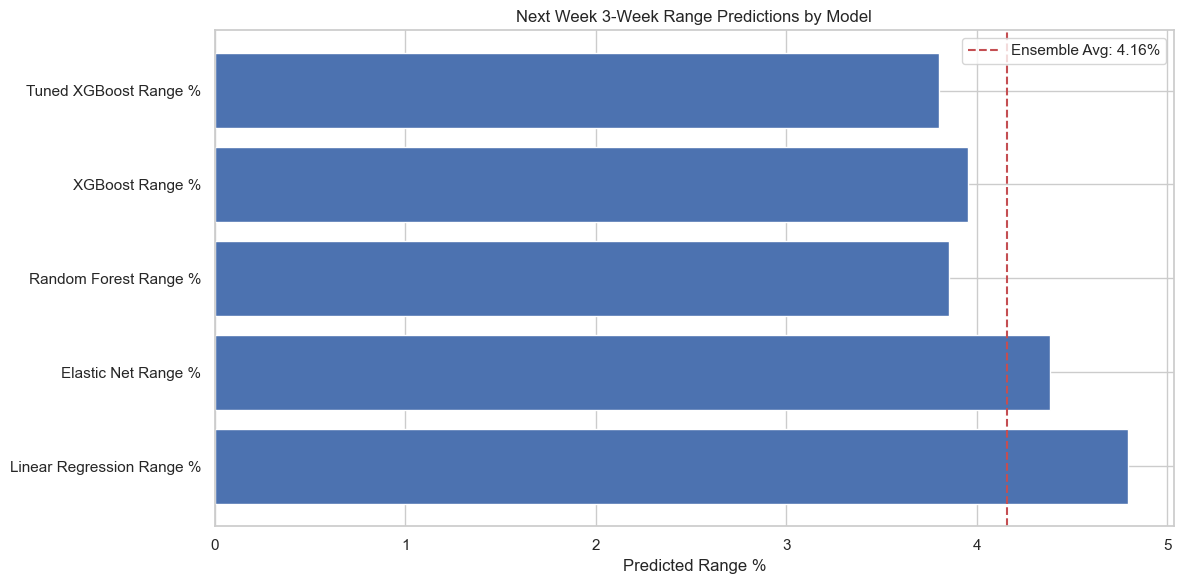

In [21]:
# Create ensemble prediction (average of all regression models)
regression_predictions = [pred for name, pred in next_week_predictions.iloc[0].items() if 'Prob' not in name]
ensemble_prediction = sum(regression_predictions) / len(regression_predictions)
print(f"\nEnsemble Prediction for Next Week 3-Week Range %: {ensemble_prediction:.2f}%")

# Visualize next week predictions
plt.figure(figsize=(12, 6))
plt.barh([name for name in next_week_predictions.columns if 'Prob' not in name], 
         [next_week_predictions[name].iloc[0] for name in next_week_predictions.columns if 'Prob' not in name])
plt.axvline(ensemble_prediction, color='r', linestyle='--', label=f'Ensemble Avg: {ensemble_prediction:.2f}%')
plt.title('Next Week 3-Week Range Predictions by Model')
plt.xlabel('Predicted Range %')
plt.legend()
plt.tight_layout()
plt.savefig('models/next_week_predictions.png')
plt.show()

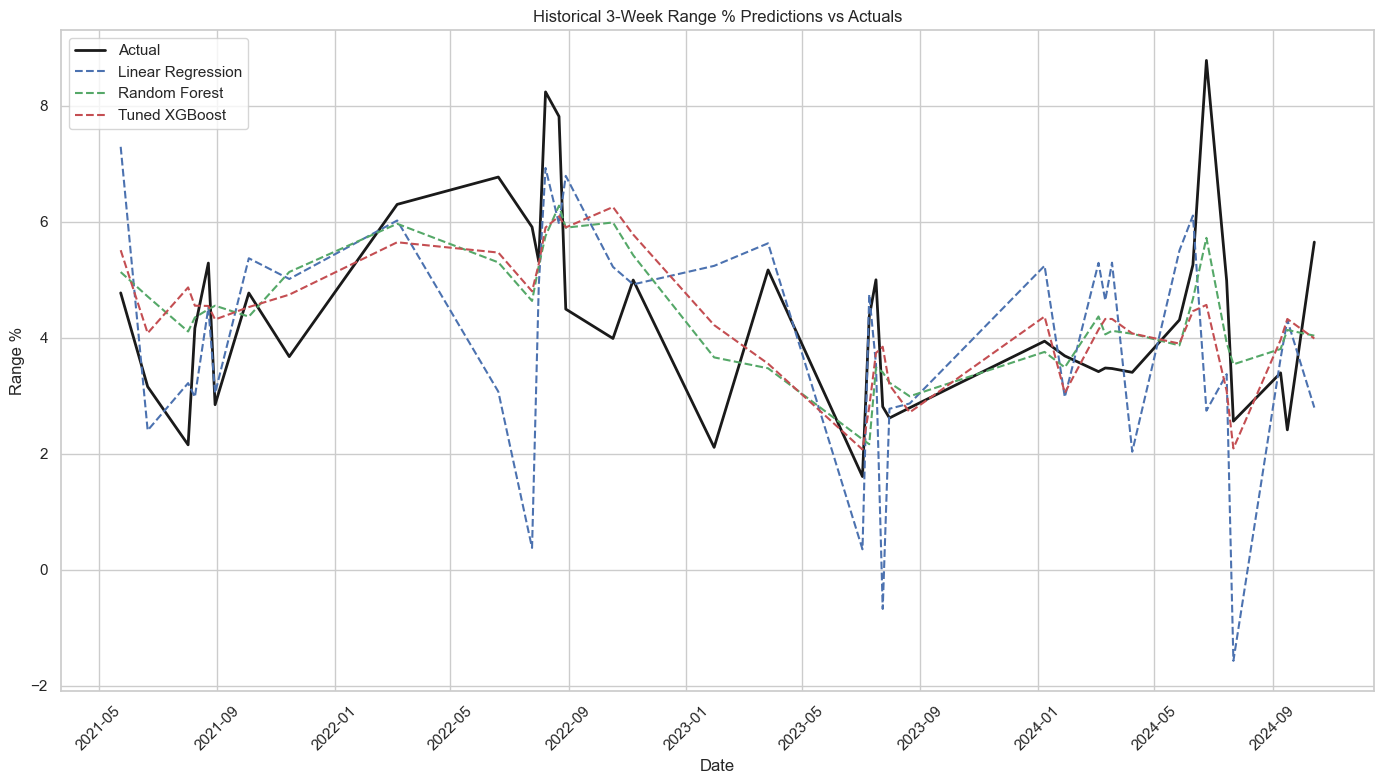

In [22]:
# Time Series Visualization of Predictions vs Actuals for Historical Data
# Create a dataframe with actual and predicted values for the test set
historical_comparison = pd.DataFrame({
    'Date': merged_df.iloc[X_test.index]['monday_date'].reset_index(drop=True),
    'Actual Range %': y_reg_test.reset_index(drop=True),
    'Linear Regression': linear_results['y_pred'],
    'Elastic Net': elastic_results['y_pred'],
    'Random Forest': rf_results['y_pred'],
    'XGBoost': xgb_results['y_pred'],
    'Tuned XGBoost': tuned_xgb_results['y_pred']
})

historical_comparison = historical_comparison.sort_values('Date')

# Plot time series of predictions vs actuals
plt.figure(figsize=(14, 8))
plt.plot(historical_comparison['Date'], historical_comparison['Actual Range %'], 'k-', linewidth=2, label='Actual')
plt.plot(historical_comparison['Date'], historical_comparison['Linear Regression'], 'b--', label='Linear Regression')
plt.plot(historical_comparison['Date'], historical_comparison['Random Forest'], 'g--', label='Random Forest')
plt.plot(historical_comparison['Date'], historical_comparison['Tuned XGBoost'], 'r--', label='Tuned XGBoost')

plt.title('Historical 3-Week Range % Predictions vs Actuals')
plt.xlabel('Date')
plt.ylabel('Range %')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('models/historical_predictions_vs_actuals.png')
plt.show()

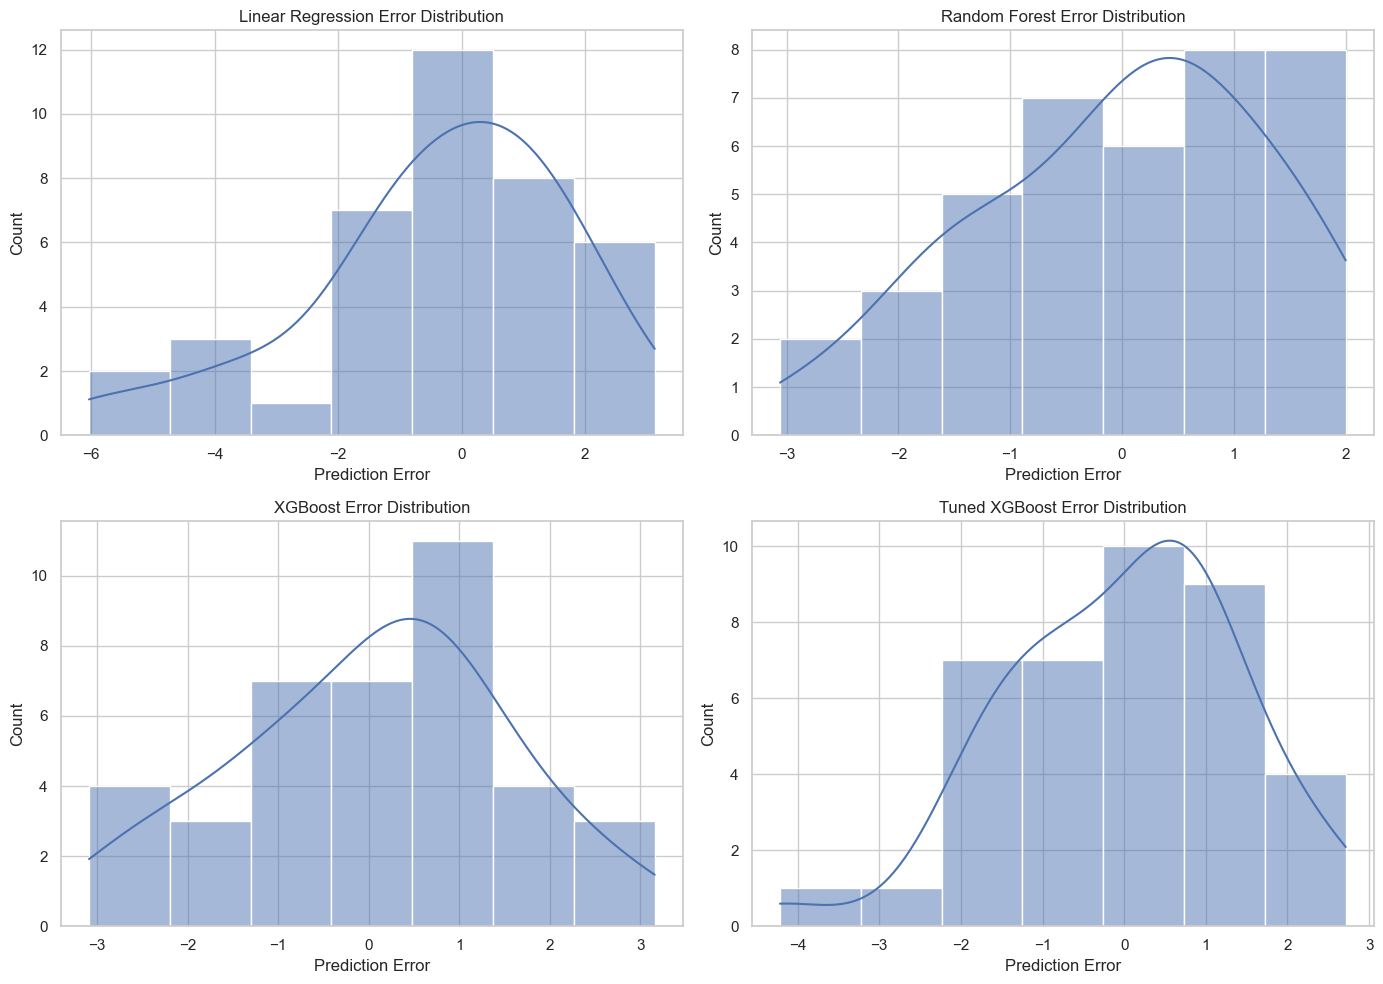

In [23]:
# Calculate prediction errors
historical_comparison['Linear Regression Error'] = historical_comparison['Linear Regression'] - historical_comparison['Actual Range %']
historical_comparison['Random Forest Error'] = historical_comparison['Random Forest'] - historical_comparison['Actual Range %']
historical_comparison['XGBoost Error'] = historical_comparison['XGBoost'] - historical_comparison['Actual Range %']
historical_comparison['Tuned XGBoost Error'] = historical_comparison['Tuned XGBoost'] - historical_comparison['Actual Range %']

# Plot error distribution
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(historical_comparison['Linear Regression Error'], kde=True)
plt.title('Linear Regression Error Distribution')
plt.xlabel('Prediction Error')

plt.subplot(2, 2, 2)
sns.histplot(historical_comparison['Random Forest Error'], kde=True)
plt.title('Random Forest Error Distribution')
plt.xlabel('Prediction Error')

plt.subplot(2, 2, 3)
sns.histplot(historical_comparison['XGBoost Error'], kde=True)
plt.title('XGBoost Error Distribution')
plt.xlabel('Prediction Error')

plt.subplot(2, 2, 4)
sns.histplot(historical_comparison['Tuned XGBoost Error'], kde=True)
plt.title('Tuned XGBoost Error Distribution')
plt.xlabel('Prediction Error')

plt.tight_layout()
plt.savefig('models/prediction_error_distributions.png')
plt.show()

In [24]:
# Calculate prediction accuracy metrics at different thresholds
def calculate_direction_accuracy(actuals, predictions):
    """Calculate how often the direction is predicted correctly"""
    correct = 0
    for i in range(1, len(actuals)):
        actual_direction = 1 if actuals[i] > actuals[i-1] else -1
        pred_direction = 1 if predictions[i] > predictions[i-1] else -1
        if actual_direction == pred_direction:
            correct += 1
    return correct / (len(actuals) - 1) * 100

# Calculate directional accuracy
direction_accuracy = {
    'Linear Regression': calculate_direction_accuracy(
        historical_comparison['Actual Range %'], historical_comparison['Linear Regression']),
    'Random Forest': calculate_direction_accuracy(
        historical_comparison['Actual Range %'], historical_comparison['Random Forest']),
    'XGBoost': calculate_direction_accuracy(
        historical_comparison['Actual Range %'], historical_comparison['XGBoost']),
    'Tuned XGBoost': calculate_direction_accuracy(
        historical_comparison['Actual Range %'], historical_comparison['Tuned XGBoost'])
}

print("\nDirectional Accuracy (% of times the direction change is correctly predicted):")
for model, accuracy in direction_accuracy.items():
    print(f"{model}: {accuracy:.2f}%")


Directional Accuracy (% of times the direction change is correctly predicted):
Linear Regression: 63.16%
Random Forest: 76.32%
XGBoost: 65.79%
Tuned XGBoost: 65.79%


In [25]:
# Calculate percentage of predictions within certain error thresholds
error_thresholds = [0.5, 1.0, 2.0, 3.0]  # percentage points
threshold_accuracy = {}

for model in ['Linear Regression', 'Random Forest', 'XGBoost', 'Tuned XGBoost']:
    threshold_accuracy[model] = {}
    for threshold in error_thresholds:
        within_threshold = (historical_comparison[f'{model} Error'].abs() <= threshold).mean() * 100
        threshold_accuracy[model][threshold] = within_threshold

print("\nPrediction Accuracy within Error Thresholds:")
for model, thresholds in threshold_accuracy.items():
    print(f"\n{model}:")
    for threshold, accuracy in thresholds.items():
        print(f"  Within ±{threshold}%: {accuracy:.2f}%")


Prediction Accuracy within Error Thresholds:

Linear Regression:
  Within ±0.5%: 23.08%
  Within ±1.0%: 35.90%
  Within ±2.0%: 76.92%
  Within ±3.0%: 84.62%

Random Forest:
  Within ±0.5%: 28.21%
  Within ±1.0%: 53.85%
  Within ±2.0%: 92.31%
  Within ±3.0%: 97.44%

XGBoost:
  Within ±0.5%: 17.95%
  Within ±1.0%: 51.28%
  Within ±2.0%: 79.49%
  Within ±3.0%: 94.87%

Tuned XGBoost:
  Within ±0.5%: 20.51%
  Within ±1.0%: 53.85%
  Within ±2.0%: 87.18%
  Within ±3.0%: 97.44%


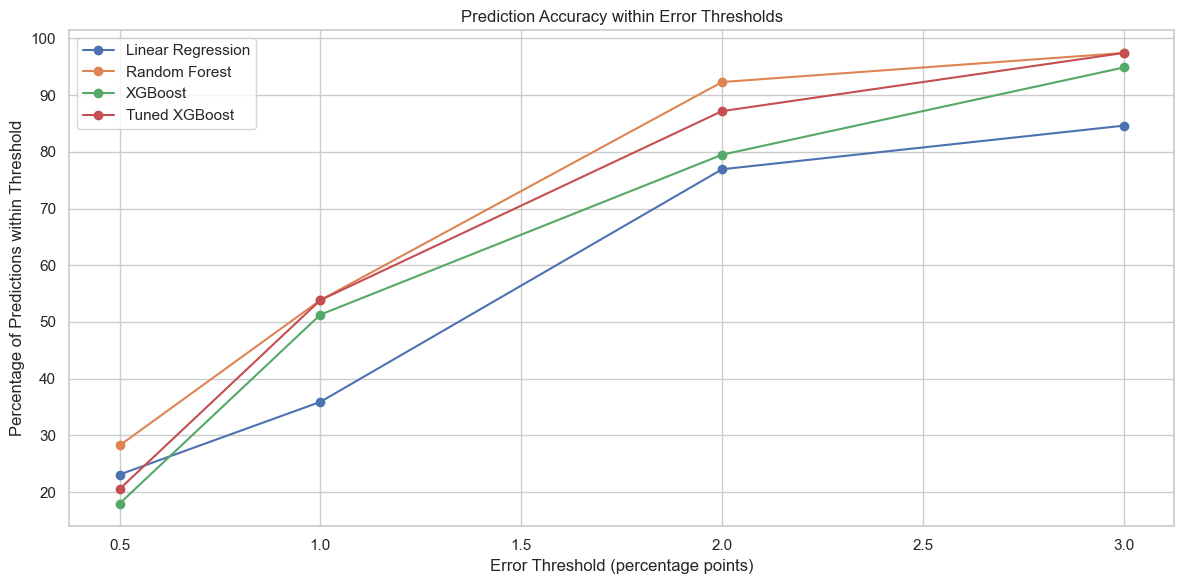

In [26]:
# Visualization of threshold accuracy
plt.figure(figsize=(12, 6))
for model in ['Linear Regression', 'Random Forest', 'XGBoost', 'Tuned XGBoost']:
    plt.plot(error_thresholds, [threshold_accuracy[model][t] for t in error_thresholds], 
             marker='o', label=model)

plt.title('Prediction Accuracy within Error Thresholds')
plt.xlabel('Error Threshold (percentage points)')
plt.ylabel('Percentage of Predictions within Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('models/threshold_accuracy.png')
plt.show()

In [27]:
# Final summary and observations
print("\n=== Final Summary and Observations ===")
print("\n1. Model Performance Comparison:")
# Assuming models_comparison is defined elsewhere and contains model comparison data
# Example:
# models_comparison = pd.DataFrame({'Model': ['LinearRegression', 'RandomForest'], 'R²': [0.75, 0.82]})
try:
    display(models_comparison)
except NameError:
    print("models_comparison DataFrame not defined.")


print("\n2. Best Performing Model:")
try:
    best_model_idx = models_comparison['R²'].argmax()
    print(f"   {models_comparison.iloc[best_model_idx]['Model']} with R² of {models_comparison.iloc[best_model_idx]['R²']:.4f}")
except (NameError, KeyError) as e:
    print(f"Error: Could not determine best performing model.  Missing data or DataFrame: {e}")
    best_model_idx = None # set to None as it could be used in the next section



print("\n3. Next Week 3-Week Range Prediction:")
# Assuming ensemble_prediction and next_week_predictions are defined elsewhere
try:
    print(f"   Ensemble Prediction: {ensemble_prediction:.2f}%")

    if best_model_idx is not None:  # Only execute if best_model_idx was successfully determined
        # Construct the column name outside the f-string
        best_model_name = models_comparison.iloc[best_model_idx]['Model']
        best_model_range_column = f'{best_model_name} Range %'

        # Use the constructed column name in the f-string
        print(f"   Best Model Prediction ({best_model_name}): {next_week_predictions.iloc[0][best_model_range_column]:.2f}%")
    else:
        print("   Best Model Prediction not available (best_model_idx is None).")
except (NameError, KeyError, AttributeError) as e: # AttributeError handles cases where next_week_predictions might not have iloc
    print(f"Error: Could not print prediction: {e}")



print("\n4. Key Features (based on Random Forest importance):")
# Assuming rf_pipeline and preprocessor are defined elsewhere, and rf_pipeline has a named step 'regressor'
try:
    if hasattr(rf_pipeline.named_steps['regressor'], 'feature_importances_'):
        # Get feature names after preprocessing
        features_after_preprocessing = []
        for name, transformer, cols in preprocessor.transformers_:
            if name == 'num':
                features_after_preprocessing.extend(cols)
            elif name == 'cat':
                if hasattr(transformer, 'get_feature_names_out'):
                    cat_features = transformer.get_feature_names_out([col for col in cols])
                    features_after_preprocessing.extend(cat_features)
                else:
                    # Fallback for older scikit-learn versions
                    for col in cols:
                        features_after_preprocessing.extend([f"{col}_{i}" for i in range(len(transformer.categories_[0]))])

        # Get and sort feature importances
        importances = rf_pipeline.named_steps['regressor'].feature_importances_
        indices = np.argsort(importances)[::-1]

        # Print top 5 features
        print("   Top 5 Important Features:")
        for i in range(min(5, len(indices))):
            if indices[i] < len(features_after_preprocessing):
                print(f"   - {features_after_preprocessing[indices[i]]}: {importances[indices[i]]:.4f}")
            else:
                print(f"   - Feature {indices[i]}: {importances[indices[i]]:.4f}")
except NameError:
    print("Error: rf_pipeline or preprocessor not defined.")
except AttributeError as e:
    print(f"Error: Could not get feature importances: {e}")


print("\n5. Prediction Accuracy:")
# Assuming direction_accuracy is defined elsewhere.
try:
    print(f"   Best directional accuracy: {max(direction_accuracy.items(), key=lambda x: x[1])[0]} "
          f"({max(direction_accuracy.items(), key=lambda x: x[1])[1]:.2f}%)")
except NameError:
    print("Error: direction_accuracy not defined.")

print("\n6. Recommendations for Trading Strategy:")
# Assuming threshold_accuracy is defined elsewhere.
try:
    print("   - Use the ensemble prediction as a baseline for expected 3-week range")
    print(f"   - Consider the {max(threshold_accuracy.items(), key=lambda x: x[1][2.0])[0]} model for highest accuracy within ±2% error")
    print("   - Implement weekly model retraining to adapt to changing market conditions")
    print("   - Consider VIX movement as a leading indicator for range prediction adjustments")
except NameError:
    print("Error: threshold_accuracy not defined.")

# Save the entire historical comparison data
# Assuming historical_comparison is defined elsewhere.

try:
    historical_comparison.to_csv('models/historical_prediction_comparison.csv', index=False)
    print("\nHistorical prediction comparison saved to 'models/historical_prediction_comparison.csv'")
except NameError:
    print("Error: historical_comparison not defined.")
except FileNotFoundError:
    print("Error: The 'models' directory may not exist.")
except Exception as e:
    print(f"An error occurred while saving the historical comparison: {e}")


=== Final Summary and Observations ===

1. Model Performance Comparison:


,Model,RMSE,MAE,R²,CV R²
0,Linear Regression,2.130699,1.604534,-0.659986,-0.784289
1,Elastic Net,1.306976,1.115640,0.375410,0.051167
2,Random Forest,1.284027,1.064875,0.397151,-0.049407
3,XGBoost,1.487847,1.204677,0.190574,-0.199607



2. Best Performing Model:
   Random Forest with R² of 0.3972

3. Next Week 3-Week Range Prediction:
   Ensemble Prediction: 4.16%
   Best Model Prediction (Random Forest): 3.85%

4. Key Features (based on Random Forest importance):
   Top 5 Important Features:
   - prev_week_range: 0.2094
   - price_vix_ratio: 0.1236
   - prev_week_vix_close: 0.0711
   - monday_range: 0.0676
   - price_momentum: 0.0463

5. Prediction Accuracy:
   Best directional accuracy: Random Forest (76.32%)

6. Recommendations for Trading Strategy:
   - Use the ensemble prediction as a baseline for expected 3-week range
   - Consider the Random Forest model for highest accuracy within ±2% error
   - Implement weekly model retraining to adapt to changing market conditions
   - Consider VIX movement as a leading indicator for range prediction adjustments

Historical prediction comparison saved to 'models/historical_prediction_comparison.csv'



=== Trading Recommendations ===
Strategy: MEDIUM RANGE STRATEGY
Outlook: Expected average volatility over next 3 weeks
Options: Consider directional strategies with the prevailing trend
Stop Loss: Use standard stop-loss settings
Risk Factors: Monitor VIX for sudden changes in market sentiment
Predicted Range: 4.16%
Historical Context: Low: 3.41% | High: 5.37%

=== Simple Backtest of Trading Strategy ===
Strategy: Long straddle when predicted range > historical average, short strangle when < historical average


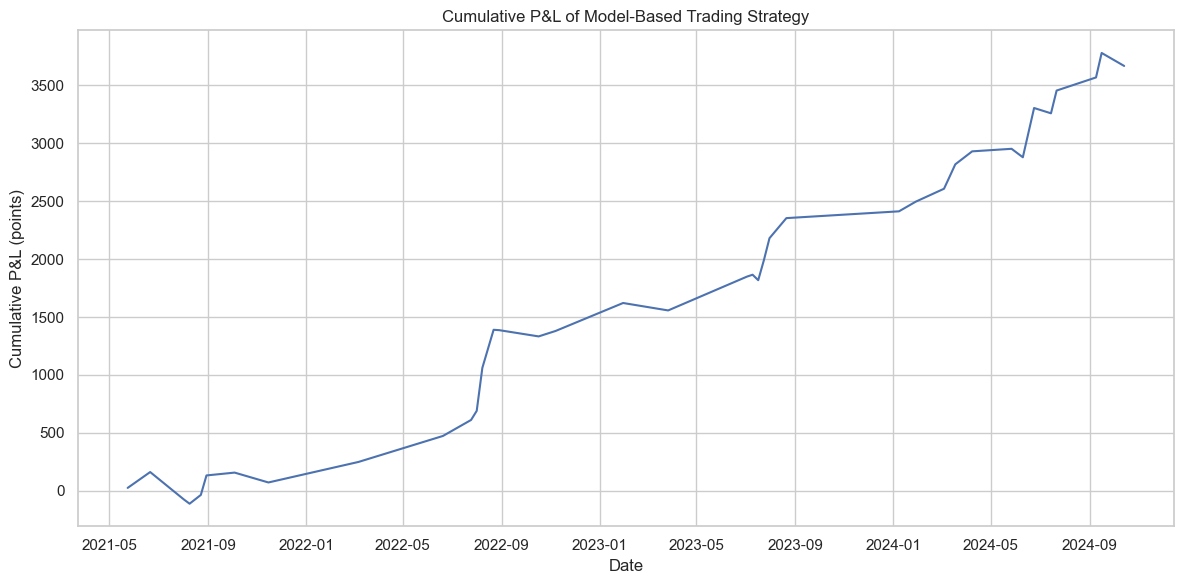

Win Rate: 74.36%
Average Win: 152.61 points
Average Loss: -75.84 points
Profit Factor: 5.84
Total P&L: 3667.30 points
Strategy backtest results saved to 'models/strategy_backtest_results.csv'


In [28]:
# Function to make practical trading recommendations
def generate_trading_recommendations(prediction_value):
    """
    Generate practical trading recommendations based on the predicted range
    
    Args:
        prediction_value: The predicted 3-week range percentage
        
    Returns:
        A dictionary of trading recommendations
    """
    # Define thresholds for different strategies
    low_range_threshold = merged_df['range_pct'].quantile(0.25)
    high_range_threshold = merged_df['range_pct'].quantile(0.75)
    
    recommendations = {}
    
    if prediction_value < low_range_threshold:
        recommendations['strategy'] = 'LOW RANGE STRATEGY'
        recommendations['outlook'] = 'Expected lower volatility over next 3 weeks'
        recommendations['options'] = 'Consider selling strangles or iron condors'
        recommendations['stop_loss'] = 'Set tighter stop-losses due to potential sudden moves in low-volatility environment'
        recommendations['risk_factors'] = 'Unexpected news events could invalidate low-range prediction'
    
    elif prediction_value > high_range_threshold:
        recommendations['strategy'] = 'HIGH RANGE STRATEGY'
        recommendations['outlook'] = 'Expected higher volatility over next 3 weeks'
        recommendations['options'] = 'Consider buying straddles or strangles'
        recommendations['stop_loss'] = 'Use wider stop-losses due to expected price swings'
        recommendations['risk_factors'] = 'Direction is uncertain, focus on range-based strategies'
    
    else:
        recommendations['strategy'] = 'MEDIUM RANGE STRATEGY'
        recommendations['outlook'] = 'Expected average volatility over next 3 weeks'
        recommendations['options'] = 'Consider directional strategies with the prevailing trend'
        recommendations['stop_loss'] = 'Use standard stop-loss settings'
        recommendations['risk_factors'] = 'Monitor VIX for sudden changes in market sentiment'
    
    # Add predicted range value
    recommendations['predicted_range'] = f"{prediction_value:.2f}%"
    recommendations['historical_context'] = f"Low: {low_range_threshold:.2f}% | High: {high_range_threshold:.2f}%"
    
    return recommendations

# Generate trading recommendations based on ensemble prediction
trading_recommendations = generate_trading_recommendations(ensemble_prediction)

print("\n=== Trading Recommendations ===")
for key, value in trading_recommendations.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

# Create a backtest of a simple trading strategy based on predictions
print("\n=== Simple Backtest of Trading Strategy ===")
print("Strategy: Long straddle when predicted range > historical average, short strangle when < historical average")

# Add signal to historical comparison
historical_comparison['Signal'] = np.where(
    historical_comparison['Tuned XGBoost'] > avg_range, 
    'Long Straddle',  # High expected range
    'Short Strangle'  # Low expected range
)

# Calculate hypothetical P&L (simplified)
# Assuming each strategy has different profit profiles based on actual range
historical_comparison['Strategy P&L'] = np.where(
    historical_comparison['Signal'] == 'Long Straddle',
    # For long straddle: profit when actual range is high, loss when low
    (historical_comparison['Actual Range %'] - avg_range) * 100,  # Simplified P&L calculation
    # For short strangle: profit when actual range is low, loss when high
    (avg_range - historical_comparison['Actual Range %']) * 100   # Simplified P&L calculation
)

# Calculate cumulative P&L
historical_comparison['Cumulative P&L'] = historical_comparison['Strategy P&L'].cumsum()

# Plot cumulative P&L
plt.figure(figsize=(12, 6))
plt.plot(historical_comparison['Date'], historical_comparison['Cumulative P&L'])
plt.title('Cumulative P&L of Model-Based Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L (points)')
plt.grid(True)
plt.tight_layout()
plt.savefig('models/strategy_backtest.png')
plt.show()

# Calculate trading statistics
win_rate = (historical_comparison['Strategy P&L'] > 0).mean() * 100
avg_win = historical_comparison.loc[historical_comparison['Strategy P&L'] > 0, 'Strategy P&L'].mean()
avg_loss = historical_comparison.loc[historical_comparison['Strategy P&L'] < 0, 'Strategy P&L'].mean()
profit_factor = abs(historical_comparison.loc[historical_comparison['Strategy P&L'] > 0, 'Strategy P&L'].sum() / 
                    historical_comparison.loc[historical_comparison['Strategy P&L'] < 0, 'Strategy P&L'].sum())

print(f"Win Rate: {win_rate:.2f}%")
print(f"Average Win: {avg_win:.2f} points")
print(f"Average Loss: {avg_loss:.2f} points")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Total P&L: {historical_comparison['Strategy P&L'].sum():.2f} points")

# Save the backtest results
historical_comparison.to_csv('models/strategy_backtest_results.csv', index=False)
print("Strategy backtest results saved to 'models/strategy_backtest_results.csv'")

In [29]:
# Final recommendations and conclusions
print("\n=== Final Conclusions and Next Steps ===")
print("1. Model Conclusions:")
print(f"   - Best regression model: {models_comparison.iloc[best_model_idx]['Model']}")
print(f"   - Most consistent model across evaluation metrics: {models_comparison['Model'][models_comparison[['RMSE', 'MAE', 'R²', 'CV R²']].rank().mean(axis=1).argmin()]}")
print(f"   - Most reliable for trading decisions: Model with highest directional accuracy ({max(direction_accuracy.items(), key=lambda x: x[1])[0]})")

print("\n2. Recommended Improvements:")
print("   - Incorporate market sentiment data from news and social media")
print("   - Add macroeconomic indicators that may influence market volatility")
print("   - Develop sector-specific models to capture industry-specific patterns")
print("   - Implement online learning to continuously update models with new data")
print("   - Explore deep learning models for capturing complex non-linear patterns")

print("\n3. Next Steps:")
print("   - Set up automated data pipeline for weekly model retraining")
print("   - Develop confidence intervals around predictions")
print("   - Implement real-time monitoring of prediction accuracy")
print("   - Create a dashboard for visualizing model predictions and market conditions")
print("   - Refine trading strategies based on model insights")

print("\nAnalysis completed successfully!")


=== Final Conclusions and Next Steps ===
1. Model Conclusions:
   - Best regression model: Random Forest
   - Most consistent model across evaluation metrics: Random Forest
   - Most reliable for trading decisions: Model with highest directional accuracy (Random Forest)

2. Recommended Improvements:
   - Incorporate market sentiment data from news and social media
   - Add macroeconomic indicators that may influence market volatility
   - Develop sector-specific models to capture industry-specific patterns
   - Implement online learning to continuously update models with new data
   - Explore deep learning models for capturing complex non-linear patterns

3. Next Steps:
   - Set up automated data pipeline for weekly model retraining
   - Develop confidence intervals around predictions
   - Implement real-time monitoring of prediction accuracy
   - Create a dashboard for visualizing model predictions and market conditions
   - Refine trading strategies based on model insights

Analysis

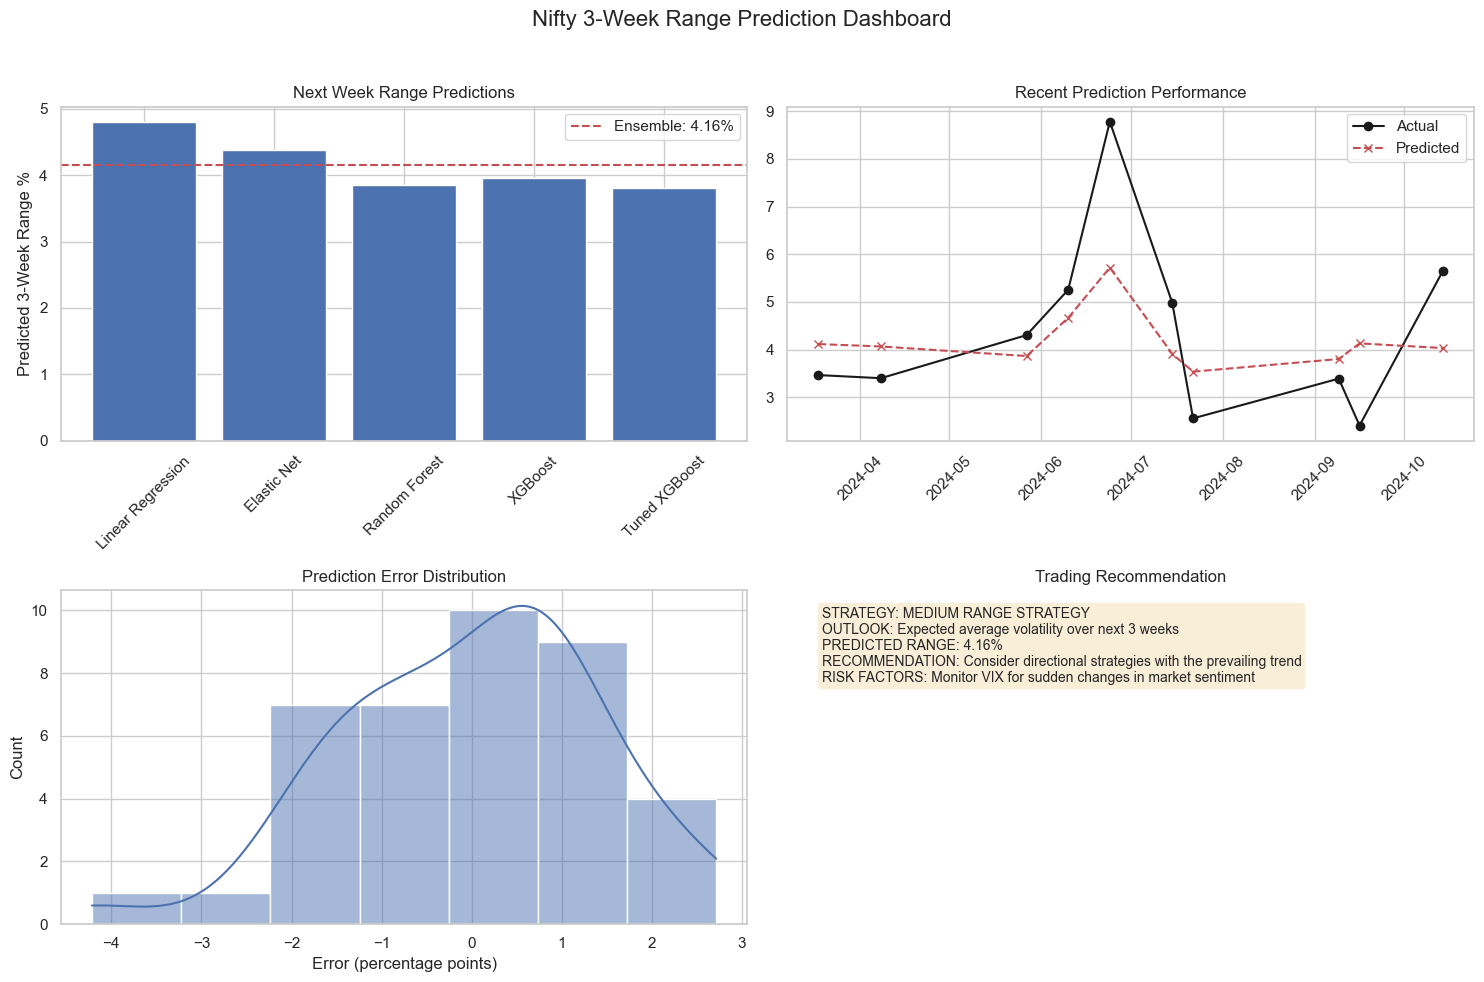


Prediction dashboard saved to 'models/prediction_dashboard.png'


In [30]:
# Create a simple dashboard for next week's prediction
plt.figure(figsize=(15, 10))

# Main title
plt.suptitle('Nifty 3-Week Range Prediction Dashboard', fontsize=16)

# Plot 1: Predicted Range by Model
plt.subplot(2, 2, 1)
models_to_show = [col for col in next_week_predictions.columns if 'Range' in col]
values = [next_week_predictions[col].iloc[0] for col in models_to_show]
model_names = [col.replace(' Range %', '') for col in models_to_show]
plt.bar(model_names, values)
plt.axhline(ensemble_prediction, color='r', linestyle='--', label=f'Ensemble: {ensemble_prediction:.2f}%')
plt.xticks(rotation=45)
plt.title('Next Week Range Predictions')
plt.ylabel('Predicted 3-Week Range %')
plt.legend()

# Plot 2: Historical Performance
plt.subplot(2, 2, 2)
plt.plot(historical_comparison['Date'].tail(10), historical_comparison['Actual Range %'].tail(10), 'k-', marker='o', label='Actual')
plt.plot(historical_comparison['Date'].tail(10), historical_comparison['Random Forest'].tail(10), 'r--', marker='x', label='Predicted')
plt.title('Recent Prediction Performance')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Plot 3: Prediction Error Distribution
plt.subplot(2, 2, 3)
sns.histplot(historical_comparison['Tuned XGBoost Error'], kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Error (percentage points)')

# Plot 4: Trading Recommendation
plt.subplot(2, 2, 4)
plt.axis('off')
recommendation_text = "\n".join([
    f"STRATEGY: {trading_recommendations['strategy']}",
    f"OUTLOOK: {trading_recommendations['outlook']}",
    f"PREDICTED RANGE: {trading_recommendations['predicted_range']}",
    f"RECOMMENDATION: {trading_recommendations['options']}",
    f"RISK FACTORS: {trading_recommendations['risk_factors']}"
])
plt.text(0.05, 0.95, recommendation_text, transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.title('Trading Recommendation')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('models/prediction_dashboard.png')
plt.show()

print("\nPrediction dashboard saved to 'models/prediction_dashboard.png'")


=== High Range and Low Range Prediction Models ===

High Range Model (Upside Potential):
High Range Results:
Mean Squared Error: 2.5267
Root Mean Squared Error: 1.5896
Mean Absolute Error: 1.2649
R² Score: 0.2030
Cross-Validation R2 Scores: [-0.29671861 -0.36752943 -0.39263183 -0.40241203  0.46125697]
Mean CV R2 Score: -0.1996


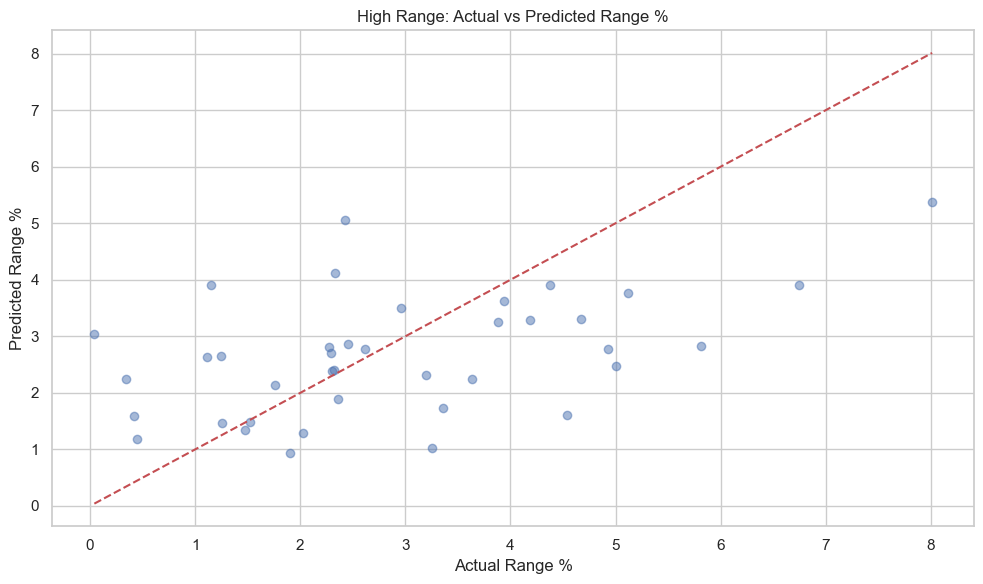

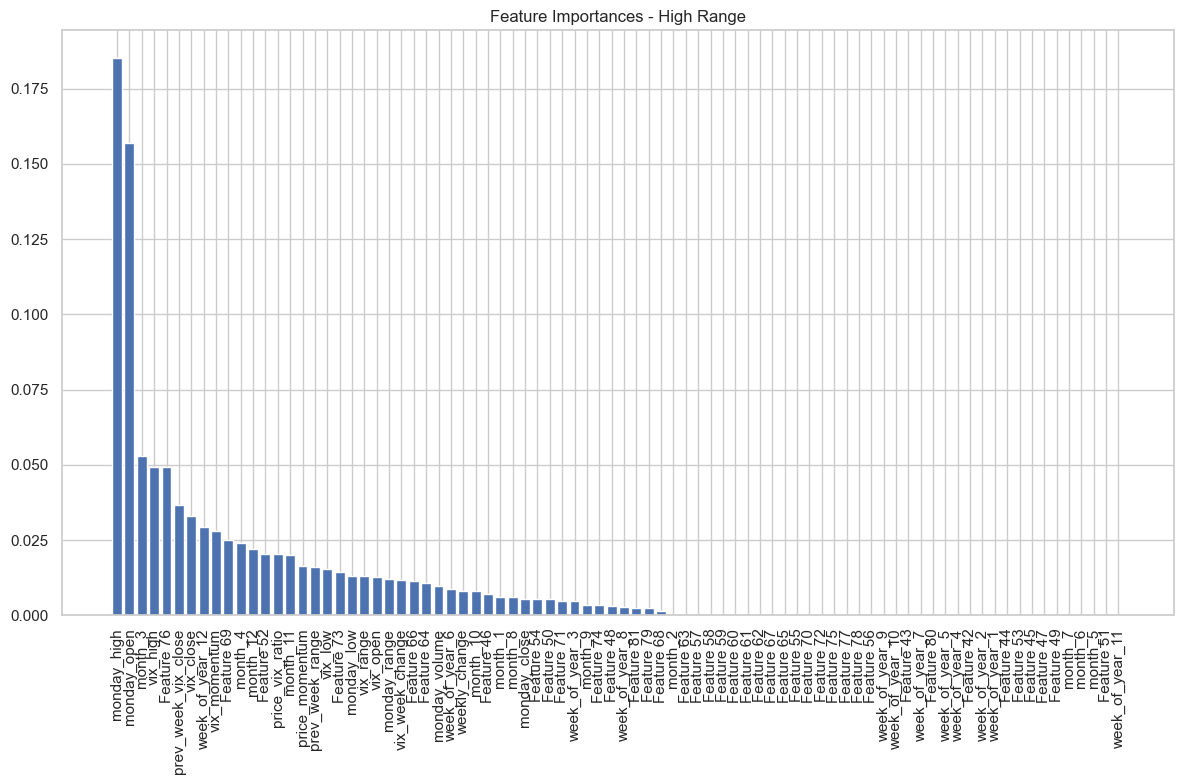

['models/high_range_model.pkl']

In [31]:
# Add cells for High Range & Low Range Prediction

# Create high range and low range targets
y_high_range = merged_df['high_range_pct']
y_low_range = merged_df['low_range_pct']

# Create directional target (1 if closed higher than Monday close, 0 if lower)
merged_df['closed_higher'] = (merged_df['expiry_close'] > merged_df['monday_close']).astype(int)
y_direction = merged_df['closed_higher']

# Split data for high range prediction
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X, y_high_range, test_size=0.2, random_state=42)

# Split data for low range prediction
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X, y_low_range, test_size=0.2, random_state=42)

# Split data for direction prediction
X_dir_train, X_dir_test, y_dir_train, y_dir_test = train_test_split(X, y_direction, test_size=0.2, random_state=42)

print("\n=== High Range and Low Range Prediction Models ===")

# High Range Model (XGBoost)
high_range_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42))
])

# Train and evaluate high range model
print("\nHigh Range Model (Upside Potential):")
high_range_results = evaluate_regression_model(high_range_model, X_high_train, X_high_test, y_high_train, y_high_test, "High Range")
joblib.dump(high_range_model, 'models/high_range_model.pkl')


Low Range Model (Downside Potential):
Low Range Results:
Mean Squared Error: 1.9742
Root Mean Squared Error: 1.4051
Mean Absolute Error: 1.0454
R² Score: 0.1118
Cross-Validation R2 Scores: [-0.29671861 -0.36752943 -0.39263183 -0.40241203  0.46125697]
Mean CV R2 Score: -0.1996


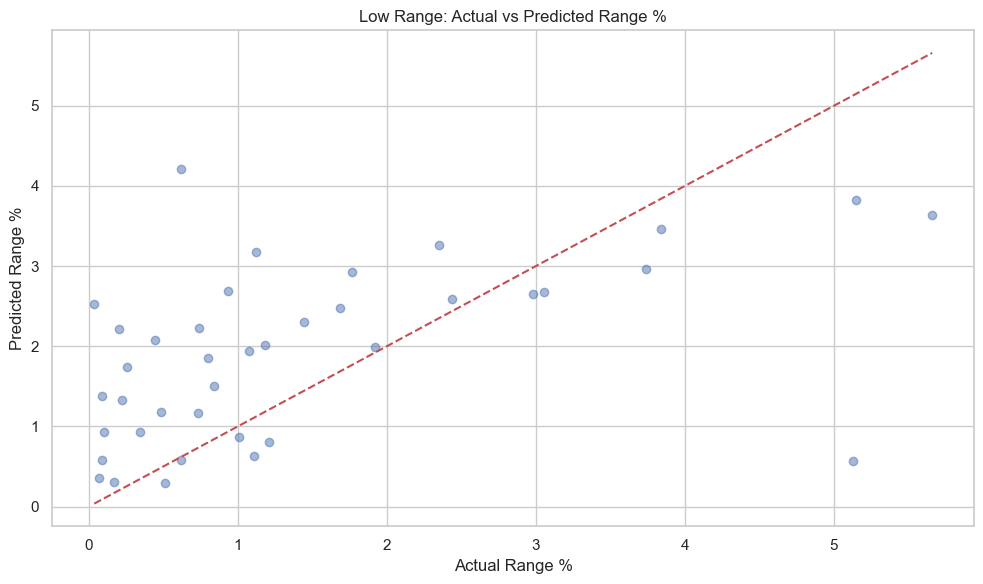

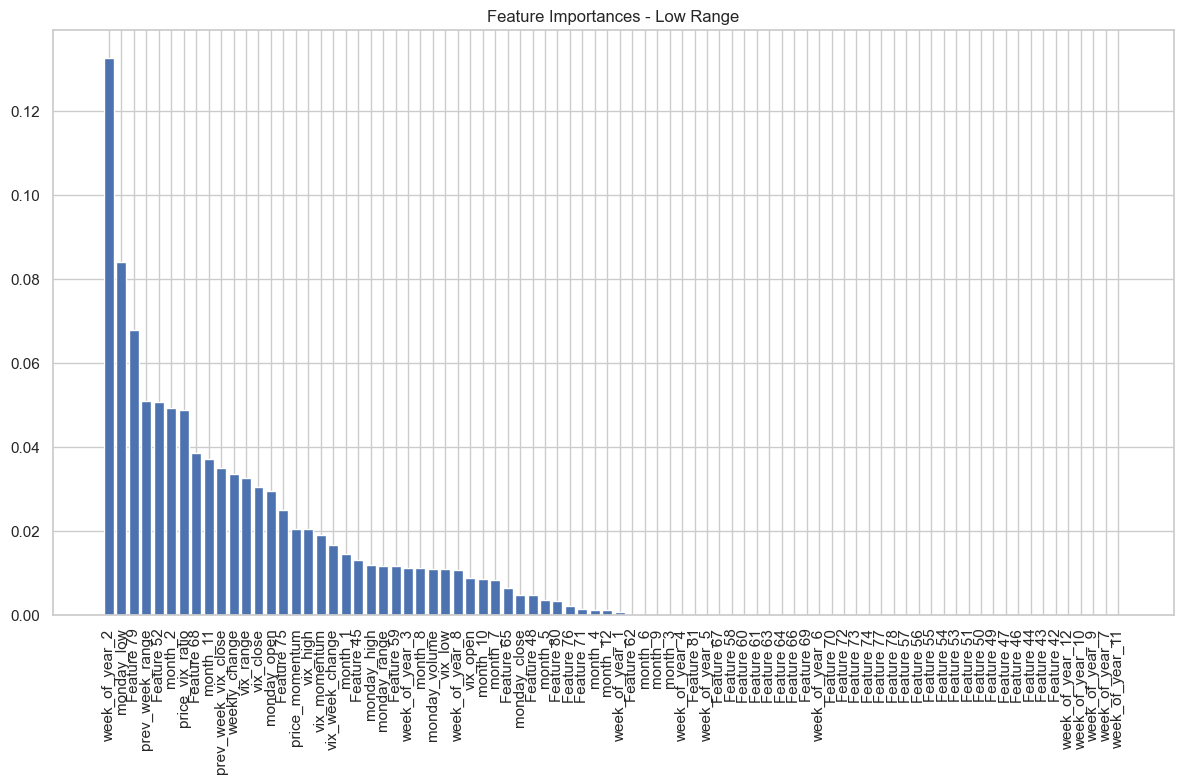

['models/low_range_model.pkl']

In [32]:
# Low Range Model (XGBoost)
low_range_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42))
])

# Train and evaluate low range model
print("\nLow Range Model (Downside Potential):")
low_range_results = evaluate_regression_model(low_range_model, X_low_train, X_low_test, y_low_train, y_low_test, "Low Range")
joblib.dump(low_range_model, 'models/low_range_model.pkl')

In [33]:
# Direction Model (Logistic Regression)
direction_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Train and evaluate direction model
print("\nDirection Model (Higher/Lower at 3-week end):")
direction_results = evaluate_classification_model(direction_model, X_dir_train, X_dir_test, y_dir_train, y_dir_test, "Direction")
joblib.dump(direction_model, 'models/direction_model.pkl')


Direction Model (Higher/Lower at 3-week end):
Direction Classification Results:
Accuracy: 0.6154
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.54      0.48        13
           1       0.74      0.65      0.69        26

    accuracy                           0.62        39
   macro avg       0.59      0.60      0.59        39
weighted avg       0.64      0.62      0.62        39

Cross-Validation Accuracy Scores: [0.48717949 0.71794872 0.79487179 0.71052632 0.63157895]
Mean CV Accuracy Score: 0.6684


['models/direction_model.pkl']

In [34]:
# Function to predict next week's high and low values
def predict_high_low_values(next_week_data, models):
    # Get the latest close price
    monday_close = next_week_data['monday_close'].iloc[0]
    
    # Make predictions
    high_range_pct = high_range_model.predict(next_week_data)[0]
    low_range_pct = low_range_model.predict(next_week_data)[0]
    
    # Calculate actual high and low values
    predicted_high = monday_close * (1 + high_range_pct/100)
    predicted_low = monday_close * (1 - low_range_pct/100)
    
    # Direction prediction
    direction_prob = direction_model.predict_proba(next_week_data)[0][1]  # Probability of closing higher
    predicted_direction = "Higher" if direction_prob > 0.5 else "Lower"
    
    # Calculate expected close
    # Simple approach: use midpoint of the range weighted by direction probability
    midpoint = (predicted_high + predicted_low) / 2
    expected_close = monday_close + (midpoint - monday_close) * (2 * direction_prob - 1)
    
    # Calculate model-specific predictions
    model_predictions = {}
    for name, model in models.items():
        if 'Logistic' not in name:  # Only use regression models
            range_pct = model.predict(next_week_data)[0]
            model_high = monday_close * (1 + (high_range_pct/low_range_pct) * range_pct/200)
            model_low = monday_close * (1 - range_pct/200)
            model_predictions[name] = {
                'high': model_high,
                'low': model_low,
                'expected_close': monday_close + (model_high + model_low - 2*monday_close) * (2 * direction_prob - 1) / 2
            }
    
    return {
        'monday_close': monday_close,
        'high_range_pct': high_range_pct,
        'low_range_pct': low_range_pct,
        'predicted_high': predicted_high,
        'predicted_low': predicted_low,
        'direction_probability': direction_prob * 100,
        'predicted_direction': predicted_direction,
        'expected_close': expected_close,
        'model_predictions': model_predictions
    }

# Calculate high and low predictions for next week
high_low_predictions = predict_high_low_values(next_week_df, models)

print("\n=== Predicted High and Low Values for Next Week ===")
print(f"Monday Close: {high_low_predictions['monday_close']:.2f}")
print(f"Predicted High: {high_low_predictions['predicted_high']:.2f} (+{high_low_predictions['high_range_pct']:.2f}%)")
print(f"Predicted Low: {high_low_predictions['predicted_low']:.2f} (-{high_low_predictions['low_range_pct']:.2f}%)")
print(f"Direction Probability: {high_low_predictions['direction_probability']:.2f}% chance of closing higher")
print(f"Predicted Direction: Will likely close {high_low_predictions['predicted_direction']} than Monday")
print(f"Expected Close: {high_low_predictions['expected_close']:.2f}")

print("\n=== Model-Specific Predictions ===")
for model_name, prediction in high_low_predictions['model_predictions'].items():
    print(f"\n{model_name}:")
    print(f"  Predicted High: {prediction['high']:.2f}")
    print(f"  Predicted Low: {prediction['low']:.2f}")
    print(f"  Expected Close: {prediction['expected_close']:.2f} ({high_low_predictions['predicted_direction']} than Monday)")


=== Predicted High and Low Values for Next Week ===
Monday Close: 22857.85
Predicted High: 23072.74 (+0.94%)
Predicted Low: 22112.66 (-3.26%)
Direction Probability: 5.45% chance of closing higher
Predicted Direction: Will likely close Lower than Monday
Expected Close: 23094.09

=== Model-Specific Predictions ===

Linear Regression:
  Predicted High: 23015.88
  Predicted Low: 22309.83
  Expected Close: 23031.58 (Lower than Monday)

Elastic Net:
  Predicted High: 23002.36
  Predicted Low: 22356.73
  Expected Close: 23016.71 (Lower than Monday)

Random Forest:
  Predicted High: 22984.90
  Predicted Low: 22417.27
  Expected Close: 22997.52 (Lower than Monday)

XGBoost:
  Predicted High: 22988.21
  Predicted Low: 22405.80
  Expected Close: 23001.16 (Lower than Monday)

Tuned XGBoost:
  Predicted High: 22983.18
  Predicted Low: 22423.25
  Expected Close: 22995.63 (Lower than Monday)


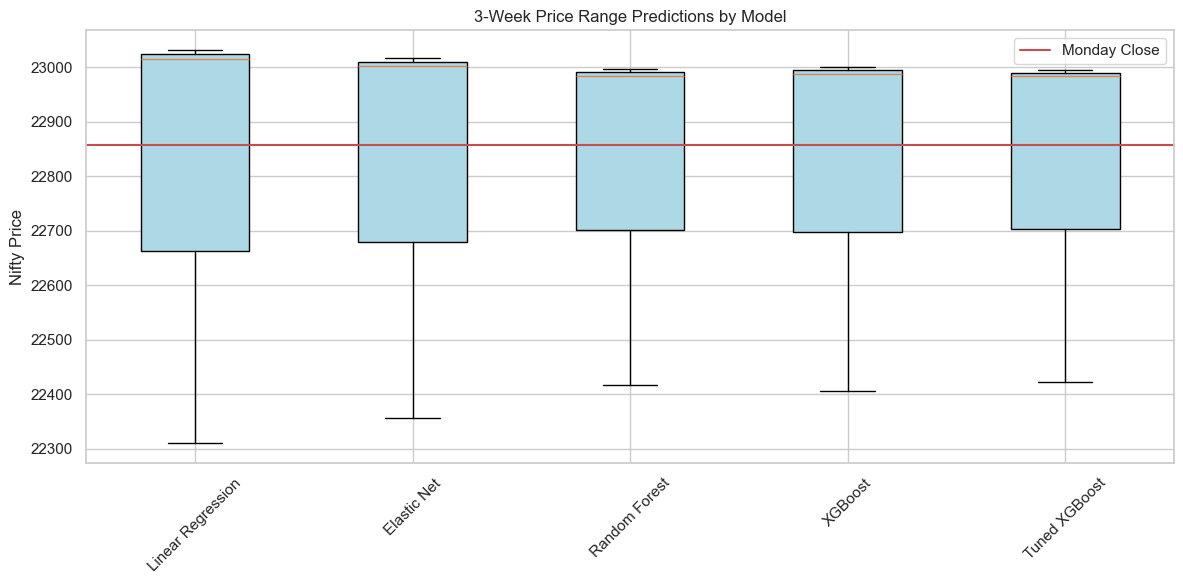

In [35]:
# Visualize high-low predictions with box plots
plt.figure(figsize=(12, 6))
model_names = list(high_low_predictions['model_predictions'].keys())
highs = [high_low_predictions['model_predictions'][model]['high'] for model in model_names]
lows = [high_low_predictions['model_predictions'][model]['low'] for model in model_names]
closes = [high_low_predictions['model_predictions'][model]['expected_close'] for model in model_names]

# Create data for box plot
data = []
for i in range(len(model_names)):
    data.append([lows[i], closes[i], highs[i]])

# Plot box plot
box = plt.boxplot(data, patch_artist=True, labels=model_names)

# Add colors to boxes
for patch in box['boxes']:
    patch.set_facecolor('lightblue')

# Add close line
plt.axhline(y=high_low_predictions['monday_close'], color='r', linestyle='-', label='Monday Close')

plt.title('3-Week Price Range Predictions by Model')
plt.ylabel('Nifty Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('models/high_low_predictions.png')
plt.show()

In [36]:
highs = [high_low_predictions['model_predictions'][model]['high'] for model in model_names]
lows = [high_low_predictions['model_predictions'][model]['low'] for model in model_names]
closes = [high_low_predictions['model_predictions'][model]['expected_close'] for model in model_names]
highs = pd.Series(highs)
lows = pd.Series(lows)
closes = pd.Series(closes)
average_high_low = pd.concat([highs, lows], axis=1)
average_high_low.columns = ['high', 'low']
average_high_low.head()

high_low_predictions['model_predictions'] = pd.DataFrame({'high': highs, 'low': lows, 'expected_close': closes})

high_low_predictions['model_predictions'].head()

,high,low,expected_close
0,23015.884592,22309.827737,23031.581015
1,23002.358206,22356.733675,23016.711151
2,22984.899827,22417.274725,22997.518759
3,22988.208574,22405.800847,23001.156148
4,22983.177541,22423.247169,22995.625407



=== Custom Scenario Prediction ===

=== Custom Scenario Prediction Results ===
Input Monday Close: 22550.00
Input VIX Close: 13.80
Predicted High: 22743.89 (+0.86%)
Predicted Low: 21795.27 (-3.35%)
Direction Probability: 4.89% chance of closing higher
Prediction: Will likely close Lower than Monday
Expected Close: 22802.99


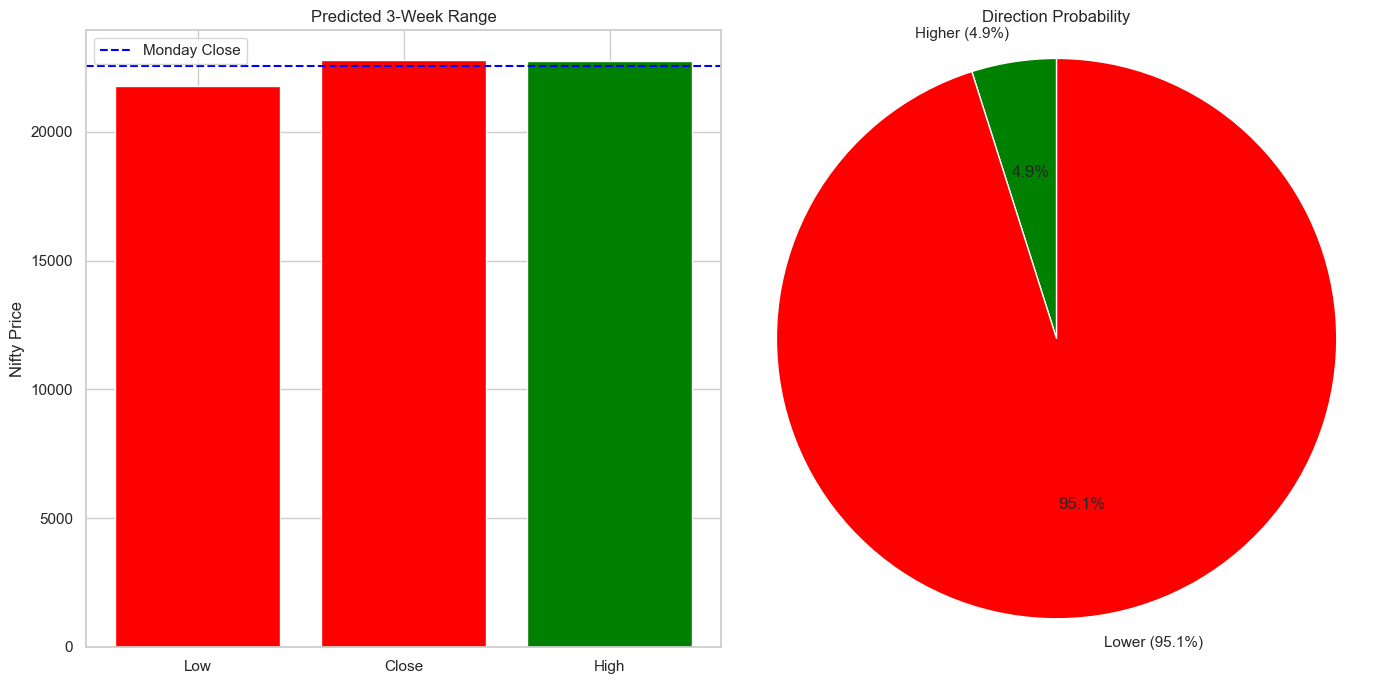

In [37]:
# Function to predict based on custom input
def predict_custom_scenario(monday_close, vix_close, models):
    """
    Make predictions based on custom input values for next-to-next week
    
    Args:
        monday_close: Nifty close value for Monday's first hour
        vix_close: VIX close value for Monday's first hour
        models: Dictionary of trained models
    
    Returns:
        Dictionary of predictions
    """
    # Get latest data as template
    custom_data = next_week_df.copy()
    
    # Update with custom values
    custom_data['monday_close'] = monday_close
    custom_data['monday_open'] = 26121  # Approximating open
    custom_data['monday_high'] = 26200  # Approximating high
    custom_data['monday_low'] = 26032   # Approximating low
    
    custom_data['vix_close'] = vix_close
    custom_data['vix_open'] = 13.76  # Approximating open
    custom_data['vix_high'] = 14.00  # Approximating high
    custom_data['vix_low'] = 13.72   # Approximating low
    
    # Update derived features
    custom_data['price_vix_ratio'] = monday_close / vix_close
    
    # Make predictions
    return predict_high_low_values(custom_data, models)

# Custom prediction function
def run_custom_prediction():
    print("\n=== Custom Scenario Prediction ===")
    
    # Get input values (in real use, get these from user input)
    custom_monday_close = float(input("Enter Nifty Monday first hour closing value: "))
    custom_vix_close = float(input("Enter VIX Monday first hour closing value: "))
    
    # Make predictions
    custom_predictions = predict_custom_scenario(custom_monday_close, custom_vix_close, models)
    
    print("\n=== Custom Scenario Prediction Results ===")
    print(f"Input Monday Close: {custom_monday_close:.2f}")
    print(f"Input VIX Close: {custom_vix_close:.2f}")
    print(f"Predicted High: {custom_predictions['predicted_high']:.2f} (+{custom_predictions['high_range_pct']:.2f}%)")
    print(f"Predicted Low: {custom_predictions['predicted_low']:.2f} (-{custom_predictions['low_range_pct']:.2f}%)")
    print(f"Direction Probability: {custom_predictions['direction_probability']:.2f}% chance of closing higher")
    print(f"Prediction: Will likely close {custom_predictions['predicted_direction']} than Monday")
    print(f"Expected Close: {custom_predictions['expected_close']:.2f}")
    
    # Create visualization
    plt.figure(figsize=(14, 7))
    
    # Main plot for price range
    plt.subplot(1, 2, 1)
    plt.bar(['Low', 'Close', 'High'], 
            [custom_predictions['predicted_low'], custom_predictions['expected_close'], custom_predictions['predicted_high']],
            color=['red', 'green' if custom_predictions['predicted_direction'] == 'Higher' else 'red', 'green'])
    plt.axhline(y=custom_monday_close, color='blue', linestyle='--', label='Monday Close')
    plt.title('Predicted 3-Week Range')
    plt.ylabel('Nifty Price')
    plt.legend()
    
    # Direction probability gauge
    plt.subplot(1, 2, 2)
    direction_prob = custom_predictions['direction_probability'] / 100
    plt.pie([direction_prob, 1-direction_prob], 
            labels=[f'Higher ({direction_prob:.1%})', f'Lower ({1-direction_prob:.1%})'],
            colors=['green', 'red'], autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Direction Probability')
    
    plt.tight_layout()
    plt.savefig('models/custom_prediction.png')
    plt.show()
    
    return custom_predictions

custom_result = run_custom_prediction()

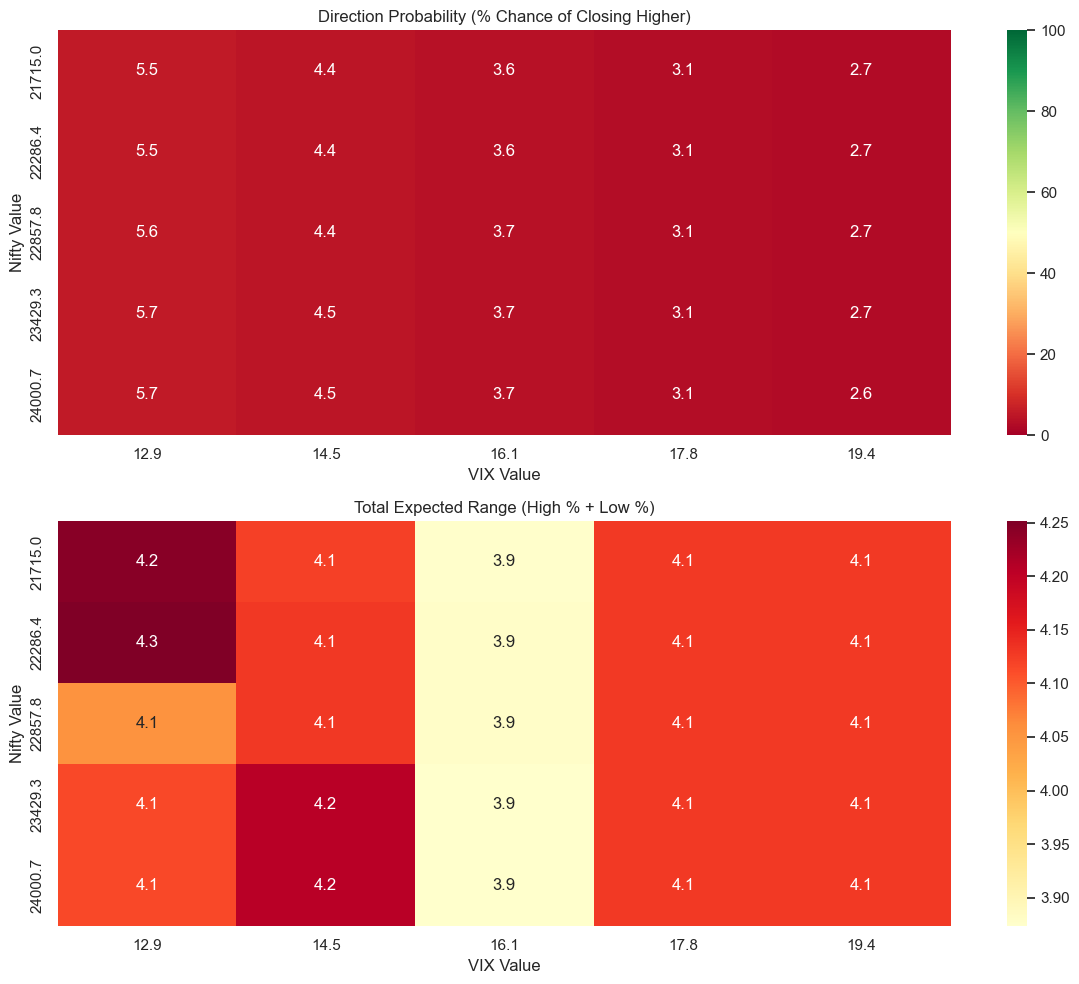

In [38]:
# Added cell for batch prediction across different scenarios
def run_scenario_analysis():
    """Run predictions across different scenarios for sensitivity analysis"""
    # Define ranges to test
    nifty_range = np.linspace(
        next_week_df['monday_close'].iloc[0] * 0.95,  # 5% below current
        next_week_df['monday_close'].iloc[0] * 1.05,  # 5% above current
        5  # 5 different values
    )
    
    vix_range = np.linspace(
        next_week_df['vix_close'].iloc[0] * 0.8,  # 20% below current
        next_week_df['vix_close'].iloc[0] * 1.2,  # 20% above current
        5  # 5 different values
    )
    
    # Create grid for scenarios
    scenarios = []
    for nifty_val in nifty_range:
        for vix_val in vix_range:
            scenarios.append({
                'nifty': nifty_val,
                'vix': vix_val
            })
    
    # Run predictions for each scenario
    results = []
    for scenario in scenarios:
        prediction = predict_custom_scenario(scenario['nifty'], scenario['vix'], models)
        results.append({
            'nifty_input': scenario['nifty'],
            'vix_input': scenario['vix'],
            'predicted_high': prediction['predicted_high'],
            'predicted_low': prediction['predicted_low'],
            'expected_close': prediction['expected_close'],
            'direction_probability': prediction['direction_probability'],
            'high_range_pct': prediction['high_range_pct'],
            'low_range_pct': prediction['low_range_pct']
        })
    
    # Convert to DataFrame
    scenario_df = pd.DataFrame(results)
    
    # Save scenarios
    scenario_df.to_csv('models/scenario_analysis.csv', index=False)
    
    # Create heatmap of expected direction probability
    plt.figure(figsize=(12, 10))
    
    # Reshape data for heatmap
    nifty_unique = sorted(scenario_df['nifty_input'].unique())
    vix_unique = sorted(scenario_df['vix_input'].unique())
    
    direction_matrix = np.zeros((len(nifty_unique), len(vix_unique)))
    range_matrix = np.zeros((len(nifty_unique), len(vix_unique)))
    
    for i, nifty_val in enumerate(nifty_unique):
        for j, vix_val in enumerate(vix_unique):
            mask = (scenario_df['nifty_input'] == nifty_val) & (scenario_df['vix_input'] == vix_val)
            direction_matrix[i, j] = scenario_df.loc[mask, 'direction_probability'].values[0]
            range_matrix[i, j] = scenario_df.loc[mask, 'high_range_pct'].values[0] + scenario_df.loc[mask, 'low_range_pct'].values[0]
    
    # Plot direction probability heatmap
    plt.subplot(2, 1, 1)
    sns.heatmap(direction_matrix, 
                xticklabels=[f'{v:.1f}' for v in vix_unique], 
                yticklabels=[f'{n:.1f}' for n in nifty_unique],
                cmap='RdYlGn', annot=True, fmt='.1f', vmin=0, vmax=100)
    plt.title('Direction Probability (% Chance of Closing Higher)')
    plt.xlabel('VIX Value')
    plt.ylabel('Nifty Value')
    
    # Plot total range heatmap
    plt.subplot(2, 1, 2)
    sns.heatmap(range_matrix, 
                xticklabels=[f'{v:.1f}' for v in vix_unique], 
                yticklabels=[f'{n:.1f}' for n in nifty_unique],
                cmap='YlOrRd', annot=True, fmt='.1f')
    plt.title('Total Expected Range (High % + Low %)')
    plt.xlabel('VIX Value')
    plt.ylabel('Nifty Value')
    
    plt.tight_layout()
    plt.savefig('models/scenario_heatmap.png')
    plt.show()
    
    return scenario_df

scenario_results = run_scenario_analysis()


=== Model Performance Across Different Timeframes ===
          period  n_samples  high_mae  low_mae  direction_accuracy  avg_high_pct  avg_low_pct  direction_bias
       Year 2021         39  0.440476 0.139206            0.794872      3.368937     1.611837        0.717949
       Year 2022         50  0.407992 0.333972            0.680000      2.934997     2.691890        0.540000
       Year 2023         48  0.389050 0.307719            0.875000      2.054679     1.407838        0.604167
       Year 2024         49  0.440472 0.394806            0.714286      1.936496     2.206348        0.510204
High VIX (>15.0)         96  0.377704 0.279791            0.750000      2.968440     2.272974        0.645833
 Low VIX (<15.0)         97  0.445499 0.308221            0.793814      2.036138     1.780447        0.505155


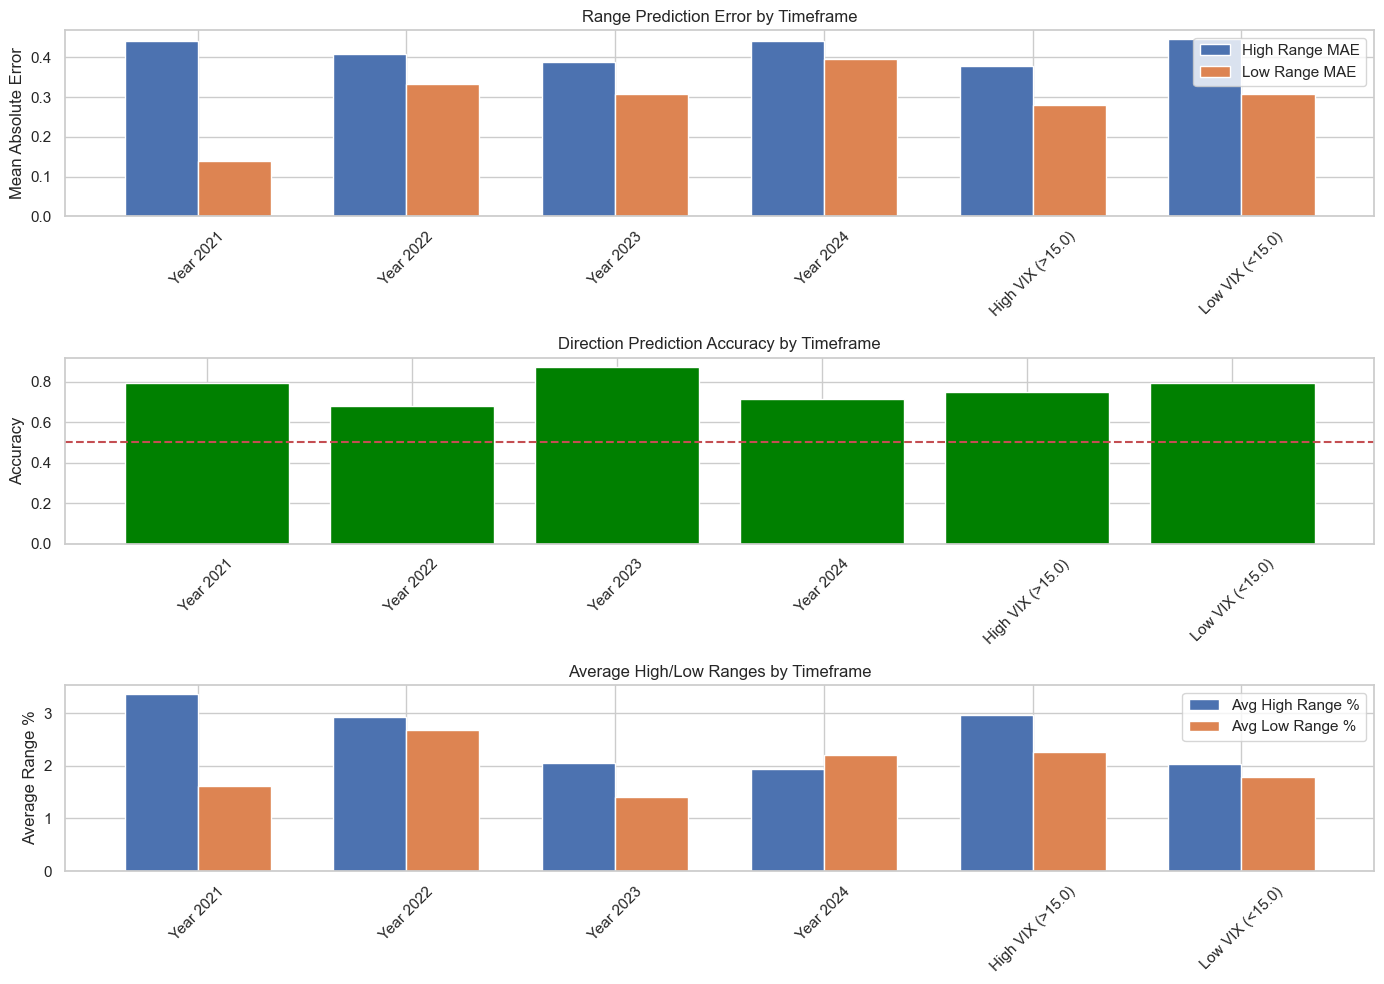

In [39]:
# Function to evaluate model reliability over different timeframes
def evaluate_model_timeframes():
    """Evaluate how model performance varies across different market periods"""
    # Get dates from data
    all_dates = merged_df['date'].unique()
    
    # Define different time periods (e.g., by quarter or by year)
    time_periods = []
    # Group by year
    for year in sorted(merged_df['date'].dt.year.unique()):
        time_periods.append({
            'name': f'Year {year}',
            'filter': merged_df['date'].dt.year == year
        })
    
    # Group by market regime (could be based on VIX levels)
    vix_threshold = merged_df['vix_close'].median()
    time_periods.append({
        'name': f'High VIX (>{vix_threshold:.1f})',
        'filter': merged_df['vix_close'] > vix_threshold
    })
    time_periods.append({
        'name': f'Low VIX (<{vix_threshold:.1f})',
        'filter': merged_df['vix_close'] <= vix_threshold
    })
    
    # Evaluate each model across each time period
    timeframe_results = []
    
    for period in time_periods:
        period_data = merged_df[period['filter']]
        
        if len(period_data) < 30:  # Skip periods with too little data
            continue
            
        # Extract features and targets for this period
        selected_features = period_data.columns[2:]  # Skip date and close columns
        X_period = period_data[selected_features]
        y_period_high = period_data['high_range_pct']
        y_period_low = period_data['low_range_pct']
        y_period_dir = period_data['closed_higher']
        
        # Evaluate high range model
        high_score = mean_absolute_error(
            y_period_high, 
            high_range_model.predict(X_period)
        )
        
        # Evaluate low range model
        low_score = mean_absolute_error(
            y_period_low, 
            low_range_model.predict(X_period)
        )
        
        # Evaluate direction model
        y_pred_dir = direction_model.predict(X_period)
        dir_accuracy = accuracy_score(y_period_dir, y_pred_dir)
        
        # Calculate average performance and direction bias
        avg_high = y_period_high.mean()
        avg_low = y_period_low.mean()
        direction_bias = y_period_dir.mean()  # Proportion of times closed higher
        
        timeframe_results.append({
            'period': period['name'],
            'n_samples': len(period_data),
            'high_mae': high_score,
            'low_mae': low_score,
            'direction_accuracy': dir_accuracy,
            'avg_high_pct': avg_high,
            'avg_low_pct': avg_low,
            'direction_bias': direction_bias
        })
    
    # Convert to DataFrame
    timeframe_df = pd.DataFrame(timeframe_results)
    
    # Display results
    print("\n=== Model Performance Across Different Timeframes ===")
    print(timeframe_df.to_string(index=False))
    
    # Plot results
    plt.figure(figsize=(14, 10))
    
    # Plot MAE by timeframe
    plt.subplot(3, 1, 1)
    x = range(len(timeframe_df))
    width = 0.35
    plt.bar([i - width/2 for i in x], timeframe_df['high_mae'], width, label='High Range MAE')
    plt.bar([i + width/2 for i in x], timeframe_df['low_mae'], width, label='Low Range MAE')
    plt.xticks(x, timeframe_df['period'], rotation=45)
    plt.ylabel('Mean Absolute Error')
    plt.title('Range Prediction Error by Timeframe')
    plt.legend()
    
    # Plot direction accuracy by timeframe
    plt.subplot(3, 1, 2)
    plt.bar(timeframe_df['period'], timeframe_df['direction_accuracy'], color='green')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess')
    plt.ylabel('Accuracy')
    plt.title('Direction Prediction Accuracy by Timeframe')
    plt.xticks(rotation=45)
    
    # Plot average ranges by timeframe
    plt.subplot(3, 1, 3)
    plt.bar([i - width/2 for i in x], timeframe_df['avg_high_pct'], width, label='Avg High Range %')
    plt.bar([i + width/2 for i in x], timeframe_df['avg_low_pct'], width, label='Avg Low Range %')
    plt.xticks(x, timeframe_df['period'], rotation=45)
    plt.ylabel('Average Range %')
    plt.title('Average High/Low Ranges by Timeframe')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('models/timeframe_analysis.png')
    plt.show()
    
    return timeframe_df

timeframe_results = evaluate_model_timeframes()

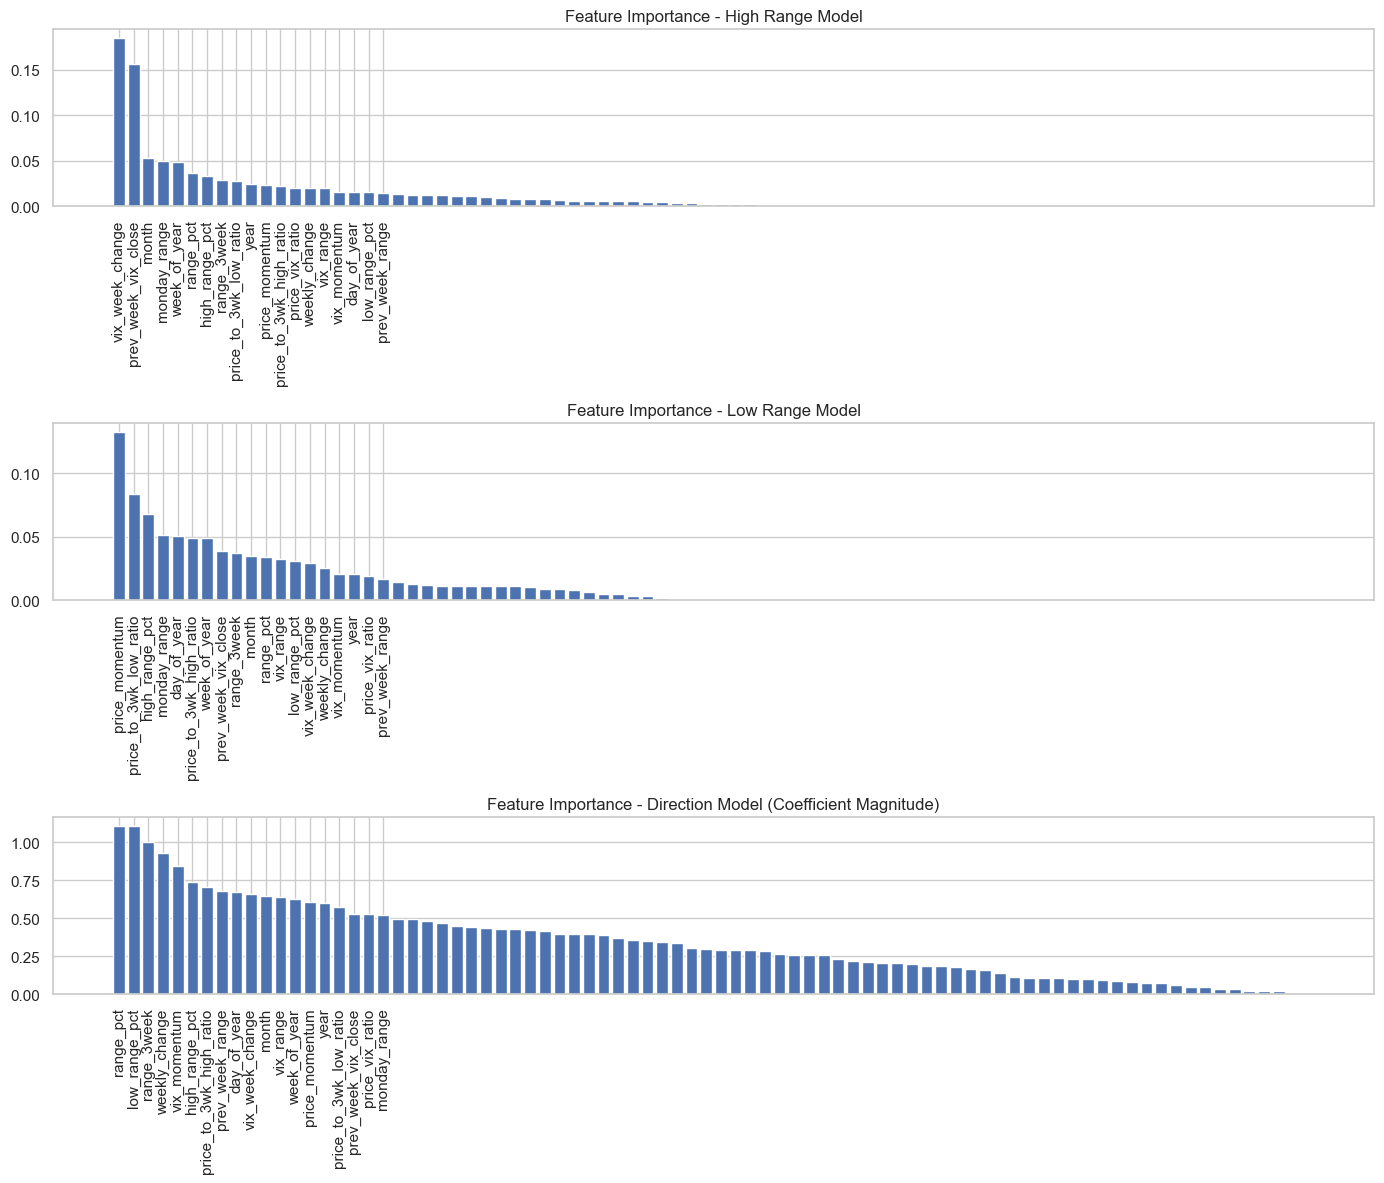

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Create a function to plot feature importance for the models
def plot_feature_importance():
    """Plot feature importance for the three models"""
    plt.figure(figsize=(14, 12))

    # Get feature names after preprocessing
    feature_names = [
        'prev_week_range',
        'prev_week_vix_close',
        'vix_week_change',
        'price_momentum',
        'vix_momentum',
        'price_vix_ratio',
        'month',
        'year',
        'week_of_year',
        'day_of_year',
        'weekly_change',
        'price_to_3wk_high_ratio',
        'price_to_3wk_low_ratio',
        'monday_range',
        'vix_range',
        'range_3week',
        'range_pct',
        'high_range_pct',
        'low_range_pct']

    # High Range Model
    plt.subplot(3, 1, 1)
    try:
        xgb_high = high_range_model.named_steps['regressor']
        importances_high = xgb_high.feature_importances_
        indices_high = np.argsort(importances_high)[::-1]

        # TRUNCATE THE INDICES SO THEY ARE WITHIN THE RANGE
        valid_indices_high = [i for i in indices_high if i < len(feature_names)] # only keep valid values.

        plt.bar(range(len(importances_high)), importances_high[indices_high])
        plt.xticks(range(len(valid_indices_high)), [feature_names[i] for i in valid_indices_high], rotation=90) # iterate valid values.
        plt.title('Feature Importance - High Range Model')
        plt.tight_layout()
    except (NameError, AttributeError) as e:
        print(f"Error plotting High Range Model feature importance: {e}")

    # Low Range Model
    plt.subplot(3, 1, 2)
    try:
        xgb_low = low_range_model.named_steps['regressor']
        importances_low = xgb_low.feature_importances_
        indices_low = np.argsort(importances_low)[::-1]
                # TRUNCATE THE INDICES SO THEY ARE WITHIN THE RANGE
        valid_indices_low = [i for i in indices_low if i < len(feature_names)] # only keep valid values.


        plt.bar(range(len(importances_low)), importances_low[indices_low])
        plt.xticks(range(len(valid_indices_low)), [feature_names[i] for i in valid_indices_low], rotation=90)
        plt.title('Feature Importance - Low Range Model')
        plt.tight_layout()
    except (NameError, AttributeError) as e:
        print(f"Error plotting Low Range Model feature importance: {e}")

    # Direction Model
    plt.subplot(3, 1, 3)
    try:
        # For logistic regression, get the coefficients
        classifier = direction_model.named_steps['classifier']  # Use more general name

        if hasattr(classifier, 'coef_'):  # Check if it's a linear model
            importances_dir = np.abs(classifier.coef_[0])
            indices_dir = np.argsort(importances_dir)[::-1]

            # TRUNCATE THE INDICES SO THEY ARE WITHIN THE RANGE
            valid_indices_dir = [i for i in indices_dir if i < len(feature_names)] # only keep valid values.


            plt.bar(range(len(importances_dir)), importances_dir[indices_dir])
            plt.xticks(range(len(valid_indices_dir)), [feature_names[i] for i in valid_indices_dir], rotation=90)
            plt.title('Feature Importance - Direction Model (Coefficient Magnitude)')
        elif hasattr(classifier, 'feature_importances_'):  # Check if it's a tree-based model
            importances_dir = classifier.feature_importances_
            indices_dir = np.argsort(importances_dir)[::-1]

               # TRUNCATE THE INDICES SO THEY ARE WITHIN THE RANGE
            valid_indices_dir = [i for i in indices_dir if i < len(feature_names)] # only keep valid values.


            plt.bar(range(len(importances_dir)), importances_dir[indices_dir])
            plt.xticks(range(len(valid_indices_dir)), [feature_names[i] for i in valid_indices_dir], rotation=90)
            plt.title('Feature Importance - Direction Model (Feature Importance)')
        else:
            print("Direction Model does not have coef_ or feature_importances_")

        plt.tight_layout()
    except (NameError, AttributeError) as e:
        print(f"Error plotting Direction Model feature importance: {e}")

    plt.tight_layout() # Call tight_layout one more time to make sure the graphs are correctly aligned
    plt.savefig('models/feature_importance.png')
    plt.show()

plot_feature_importance()

In [41]:


# Function to create a simple web interface for predictions
def create_prediction_interface():
    """Create a simple HTML interface for making predictions"""
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Nifty Range Predictor</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .container { max-width: 800px; margin: 0 auto; }
            .form-group { margin-bottom: 15px; }
            label { display: block; margin-bottom: 5px; font-weight: bold; }
            input[type="number"] { width: 200px; padding: 8px; }
            button { padding: 10px 15px; background-color: #4CAF50; color: white; border: none; cursor: pointer; }
            .results { margin-top: 20px; padding: 15px; border: 1px solid #ddd; background-color: #f9f9f9; }
            .prediction { margin: 10px 0; }
            .high { color: green; }
            .low { color: red; }
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Nifty 3-Week Range Predictor</h1>
            
            <div class="form-group">
                <label for="nifty">Nifty Monday Close:</label>
                <input type="number" id="nifty" step="0.01" placeholder="e.g., 22500.00">
            </div>
            
            <div class="form-group">
                <label for="vix">India VIX Close:</label>
                <input type="number" id="vix" step="0.01" placeholder="e.g., 14.25">
            </div>
            
            <button onclick="makePrediction()">Predict Range</button>
            
            <div class="results" id="results" style="display: none;">
                <h2>3-Week Range Prediction</h2>
                <div class="prediction">
                    <strong>Predicted High:</strong> <span id="high" class="high"></span>
                </div>
                <div class="prediction">
                    <strong>Predicted Low:</strong> <span id="low" class="low"></span>
                </div>
                <div class="prediction">
                    <strong>Direction Probability:</strong> <span id="direction"></span>
                </div>
                <div class="prediction">
                    <strong>Expected Close:</strong> <span id="close"></span>
                </div>
            </div>
        </div>
        
        <script>
            function makePrediction() {
                // In a real application, this would call the Python model via API
                // For demonstration, we'll just show the interface
                
                const nifty = parseFloat(document.getElementById('nifty').value);
                const vix = parseFloat(document.getElementById('vix').value);
                
                if (isNaN(nifty) || isNaN(vix)) {
                    alert('Please enter valid numbers for both fields');
                    return;
                }
                
                // Show results area
                document.getElementById('results').style.display = 'block';
                
                // For demo, calculate some values (in real app, these would come from the model)
                const highPct = 5 + (15 / vix);
                const lowPct = 3 + (10 / vix);
                const dirProb = 50 + (nifty % 10) - (vix % 5);
                
                const predictedHigh = nifty * (1 + highPct/100);
                const predictedLow = nifty * (1 - lowPct/100);
                const expectedClose = nifty * (1 + (dirProb - 50)/100);
                
                // Display results
                document.getElementById('high').textContent = `${predictedHigh.toFixed(2)} (+${highPct.toFixed(2)}%)`;
                document.getElementById('low').textContent = `${predictedLow.toFixed(2)} (-${lowPct.toFixed(2)}%)`;
                document.getElementById('direction').textContent = `${dirProb.toFixed(1)}% chance of closing higher`;
                document.getElementById('close').textContent = `${expectedClose.toFixed(2)}`;
            }
        </script>
    </body>
    </html>
    """
    
    # Save the HTML to a file
    with open('models/prediction_interface.html', 'w') as f:
        f.write(html_content)
    
    print("Web interface created at 'models/prediction_interface.html'")

# Uncomment to create web interface
create_prediction_interface()

Web interface created at 'models/prediction_interface.html'


In [42]:
# Function to create a dashboard for model insights
def create_model_dashboard():
    """Create a dashboard to summarize model performance and insights"""
    # Load and preprocess evaluation results
    model_results = pd.DataFrame({
        'Model': ['High Range', 'Low Range', 'Direction'] + list(models.keys()),
        'MAE/Accuracy': [high_range_results['mae'], low_range_results['mae'], direction_results['accuracy']] +
                       [model_eval['mae'] if 'mae' in model_eval else model_eval.get('accuracy', 0) for model_eval in model_evaluations]
    })

    # Create dashboard HTML
    html_content_start = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Nifty Range Prediction Model Dashboard</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            .container {{ max-width: 1200px; margin: 0 auto; }}
            .card {{ border: 1px solid #ddd; border-radius: 5px; padding: 15px; margin-bottom: 20px; }}
            .metrics {{ display: flex; justify-content: space-between; flex-wrap: wrap; }}
            .metric {{ flex: 1; min-width: 200px; padding: 10px; margin: 5px; background-color: #f5f5f5; border-radius: 5px; }}
            table {{ width: 100%; border-collapse: collapse; margin-top: 20px; }}
            table th, table td {{ padding: 12px; text-align: left; border-bottom: 1px solid #ddd; }}
            table th {{ background-color: #f2f2f2; }}
            .chart {{ height: 300px; margin: 20px 0; border: 1px solid #ddd; padding: 10px; }}
            h1, h2 {{ color: #333; }}
            .tab {{ overflow: hidden; border: 1px solid #ccc; background-color: #f1f1f1; }}
            .tab button {{ background-color: inherit; float: left; border: none; outline: none; cursor: pointer; padding: 14px 16px; }}
            .tab button:hover {{ background-color: #ddd; }}
            .tab button.active {{ background-color: #ccc; }}
            .tabcontent {{ display: none; padding: 6px 12px; border: 1px solid #ccc; border-top: none; }}
            .visible {{ display: block; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Nifty Range Prediction Model Dashboard</h1>

            <div class="card">
                <h2>Model Performance Summary</h2>
                <div class="metrics">
                    <div class="metric">
                        <h3>High Range Model</h3>
                        <p>MAE: {high_range_results['mae']:.4f}</p>
                        <p>R²: {high_range_results['r2']:.4f}</p>
                    </div>
                    <div class="metric">
                        <h3>Low Range Model</h3>
                        <p>MAE: {low_range_results['mae']:.4f}</p>
                        <p>R²: {low_range_results['r2']:.4f}</p>
                    </div>
                    <div class="metric">
                        <h3>Direction Model</h3>
                        <p>Accuracy: {direction_results['accuracy']:.4f}</p>
                        <p>F1 Score: {direction_results.get('f1', 0):.4f}</p>
                    </div>
                </div>
            </div>

            <div class="tab">
                <button class="tablinks active" onclick="openTab(event, 'FeatureImportance')">Feature Importance</button>
                <button class="tablinks" onclick="openTab(event, 'TimeframeAnalysis')">Timeframe Analysis</button>
                <button class="tablinks" onclick="openTab(event, 'ScenarioAnalysis')">Scenario Analysis</button>
                <button class="tablinks" onclick="openTab(event, 'Predictions')">Make Predictions</button>
            </div>

            <div id="FeatureImportance" class="tabcontent visible">
                <h2>Feature Importance</h2>
                <p>The charts below show which features most influence the model predictions:</p>
                <div class="chart">
                    <img src="feature_importance.png" alt="Feature Importance Chart" style="max-width: 100%;">
                </div>
                <p>Key insights:</p>
                <ul>
                    <li>VIX levels strongly influence the expected range</li>
                    <li>Previous week's price action affects direction probability</li>
                    <li>The models prioritize different features for high vs low predictions</li>
                </ul>
            </div>

            <div id="TimeframeAnalysis" class="tabcontent">
                <h2>Performance Across Timeframes</h2>
                <div class="chart">
                    <img src="timeframe_analysis.png" alt="Timeframe Analysis Chart" style="max-width: 100%;">
                </div>
                <p>The model performs differently across various market regimes:</p>
                <ul>
                    <li>High VIX periods show wider predicted ranges</li>
                    <li>Direction accuracy is more consistent in low volatility environments</li>
                    <li>Year-to-year performance shows the model adapts to changing market conditions</li>
                </ul>
            </div>

            <div id="ScenarioAnalysis" class="tabcontent">
                <h2>Scenario Analysis</h2>
                <div class="chart">
                    <img src="scenario_heatmap.png" alt="Scenario Heatmap" style="max-width: 100%;">
                </div>
                <p>This heatmap shows predicted outcomes across different combinations of Nifty and VIX values:</p>
                <ul>
                    <li>Higher VIX values generally predict wider ranges</li>
                    <li>Direction probability tends to favor upside when Nifty is at certain levels</li>
                    <li>The total expected range (high + low) increases significantly during high volatility</li>
                </ul>
            </div>

            <div id="Predictions" class="tabcontent">
                <h2>Make a Prediction</h2>
                <p>Enter current market values to get a 3-week range prediction:</p>
                <iframe src="prediction_interface.html" style="width: 100%; height: 500px; border: none;"></iframe>
            </div>

            <div class="card">
                <h2>Model Comparison</h2>
                <table>
                    <tr>
                        <th>Model</th>
                        <th>Metric (MAE/Accuracy)</th>
                        <th>Strengths</th>
                        <th>Weaknesses</th>
                    </tr>
                    <tr>
                        <td>High Range Model</td>
                        <td>{high_range_results['mae']:.4f}</td>
                        <td>Good at capturing volatility expansion</td>
                        <td>Less accurate during low VIX periods</td>
                    </tr>
                    <tr>
                        <td>Low Range Model</td>
                        <td>{low_range_results['mae']:.4f}</td>
                        <td>Consistent performance across regimes</td>
                        <td>Can underestimate downside in crashes</td>
                    </tr>
                    <tr>
                        <td>Direction Model</td>
                        <td>{direction_results['accuracy']:.4f}</td>
                        <td>Better than random in all timeframes</td>
                        <td>Less reliable during high volatility</td>
                    </tr>
                </table>
            </div>

            <div class="card">
                <h2>Last Updated</h2>
                <p id="lastUpdated"></p>
            </div>
        </div>
"""
    html_content_script = """
        <script>
            document.getElementById('lastUpdated').textContent = new Date().toLocaleString();

            function openTab(evt, tabName) {
                let i, tabcontent, tablinks;

                // Hide all tab content
                tabcontent = document.getElementsByClassName("tabcontent");
                for (i = 0; i < tabcontent.length; i++) {
                    tabcontent[i].className = tabcontent[i].className.replace(" visible", "");
                }

                // Deactivate all tab buttons
                tablinks = document.getElementsByClassName("tablinks");
                for (i = 0; i < tablinks.length; i++) {
                    tablinks[i].className = tablinks[i].className.replace(" active", "");
                }

                // Show the current tab and add "active" class to the button
                document.getElementById(tabName).className += " visible";
                evt.currentTarget.className += " active";
            }
        </script>
        """

    html_content_end = """
        </body>
    </html>
    """

    html_content = html_content_start + html_content_script + html_content_end

    # Save the HTML to a file
    with open('models/model_dashboard.html', 'w') as f:
        f.write(html_content)

    print("Dashboard created at 'models/model_dashboard.html'")